# Summary
In this notebook we build a dataloader that takes SHLs individual signals, a model from the `upstream-seq2seq` task and returns imputed signals.
Later, we will also add an option to retrain the model and train the two tasks together.

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_12_signals_of_three_sources(reading, predicted, plot_saving_path):
    """
    plot a 12 electrodes reading of before/after. For example, before and after corruption,
    and actutal vs. predicted.
    """
    fig, axs = plt.subplots(6, 2, figsize = (20,20))

    leads = ['LI', 'LII', 'LIII', 'aVF', 'aVL', 'aVR','V1','V2','V3','V4','V5','V6']
    s=0
    for ax in axs.flat:
        ax.plot(reading[s])
        ax.plot(predicted[s])
        ax.set_title(leads[s],fontsize=9)
        s+=1
    fig.suptitle('Blue-Original; Orange-Predicted')
    plt.tight_layout()
    if plot_saving_path:
        plt.savefig(f'{plot_saving_path}.png')
    plt.show()


In [5]:
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
from typing import List
import pandas as pd
import torch



class DataGenerator():
    def __init__(self,
                 metadata_file_path:str,   # path to metadata file
                 data_folder_path:str,     # path to individual signals
                 sample:str,               # sample we want to create a generator to. Either train, validation or test
                 targets:List,             # list of targets we want train on
                 batch_size:int,           # batch size
                 leads = np.arange(12),
                 shuffle:bool = True,       # Whether to shuffle the list of IDs at the end of each epoch.
                 fillna=None,
                 minimal_number_of_leads=None,
                 imputation_model = None
                 ):
        assert sample in ['train', 'validation', 'test'], "sample has to be in ['train', 'validation', 'test']"
        self.metadata = pd.read_csv(metadata_file_path)
        self.metadata=self.metadata[self.metadata['sample'] == sample].reset_index(drop=True)
        self.targets = targets
        self.data_path = data_folder_path
        self.list_IDs = self.metadata['reading'].values
        self.indices = np.arange(len(self.list_IDs))
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.fillna=fillna
        self.minimal_number_of_leads=minimal_number_of_leads
        self.leads_mask = leads

        if imputation_model:
            pass

    def _get_sample(self, signal_index):
        """
        load the relevant <lead> reading .npy file from <data_folder_path>. 
        Inputs:
        - signal_index: int
        - data_folder_path:str. The path to the folder when the desired file can be loaded from
        """

        file_name = f'{signal_index}.npy'
        X = np.load(self.data_path+file_name,allow_pickle=True)
        y = self.metadata[self.metadata['reading'] == signal_index][self.targets].values
        if len(y)>1:
            y = np.expand_dims(y[0],-1)
        return X,y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        import random
        if self.shuffle == True:
            # np.random.shuffle(self.indices)
            self.metadata = self.metadata.sample(frac=1).reset_index(drop=True)
    
    def __data_generation(self, list_IDs_temp):
        """
        Get a list of persons IDs and return a batch of signals.
        """

        samples = [self._get_sample(signal_index) for signal_index in list_IDs_temp]
        X = np.array([sample[0] for sample in samples])
        y = np.array([sample[1] for sample in samples]) 
        
        if self.fillna is not None:
            X = np.nan_to_num(X, nan=self.fillna)

        if self.minimal_number_of_leads:
            mask = np.array([np.count_nonzero(~np.isnan(X[j][:,0]))>self.minimal_number_of_leads for j in range(len(X))])
            X = X[mask]
            y = y[mask]

        # take only relevant leads
        X = np.array([X[i][self.leads_mask] for i in range(X.shape[0])])

        return X,y
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    
    def __getitem__(self, index):
        'Generate one batch of data using __data_generation'
        # Generate indexes of the batch
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indices]

        # Generate data
        X,y = self.__data_generation(list_IDs_temp)
        
        return X,y



# Run

In [18]:
metadata_path = '/Users/davidharar/Documents/School/thesis/downstream_classification/data/combined_data/metadata_only_existant_readings_09042023.csv'
individual_signals_path = '/Users/davidharar/Documents/School/thesis/downstream_classification/data/individual-signals/'
sample='train'
targets=['one_year_until_death']
batch_size=4


# --------------------------------
# Usage example
# --------------------------------

train_generator = DataGenerator(
    metadata_file_path= metadata_path,              # path to metadata file
    data_folder_path = individual_signals_path,     # path to individual signals
    sample=sample,                                  # sample we want to create a generator to. Either train, validation or test
    targets=targets,                                # list of targets we want train on
    batch_size=batch_size,                          # batch size
    shuffle=True,                                    # Whether to shuffle the list of IDs at the end of each epoch.
    fillna=0
                 )

X,y = train_generator.__getitem__(1224)
print(X.shape, y.shape)
X,y



(4, 12, 450) (4, 1, 1)


(array([[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]],
 
        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.

# Sandbox

## Load Model

In [2]:

from modeling.Transformer import TSTransformerEncoder
import torch

input_dimension          = 12
output_dimension         = 12
hidden_dimmension        = 64
attention_heads          = None
decoder_number_of_layers = 8
positional_encodings     = False
dropout                  = 0.4
clip                     = 1
device                   = 'cuda'
model = TSTransformerEncoder(input_dimension, output_dimension, 
                    hidden_dimmension, attention_heads, 
                    decoder_number_of_layers, positional_encodings,dropout).to(device)
model.load_state_dict(torch.load('/Users/davidharar/Documents/School/thesis/upstream_seq2seq/models/exp4-base-version-with-train-by-sample-window-450.pt'))
print(model)


64 1
TSTransformerEncoder(
  (project_input): Linear(in_features=12, out_features=64, bias=True)
  (encoder): Linear(in_features=12, out_features=64, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.4, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=512, bias=True)
        (dropout): Dropout(p=0.4, inplace=False)
        (linear2): Linear(in_features=512, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.4, inplace=False)
        (dropout2): Dropout(p=0.4, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=64, o

/opt/homebrew/Caskroom/miniforge/base/envs/torch-gpu/lib/python3.8/site-packages/torch/nn/modules/transformer.py:218: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because  self.layers[0].self_attn.batch_first was not True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


## See that it works

64 1


/opt/homebrew/Caskroom/miniforge/base/envs/torch-gpu/lib/python3.8/site-packages/torch/nn/modules/transformer.py:218: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because  self.layers[0].self_attn.batch_first was not True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


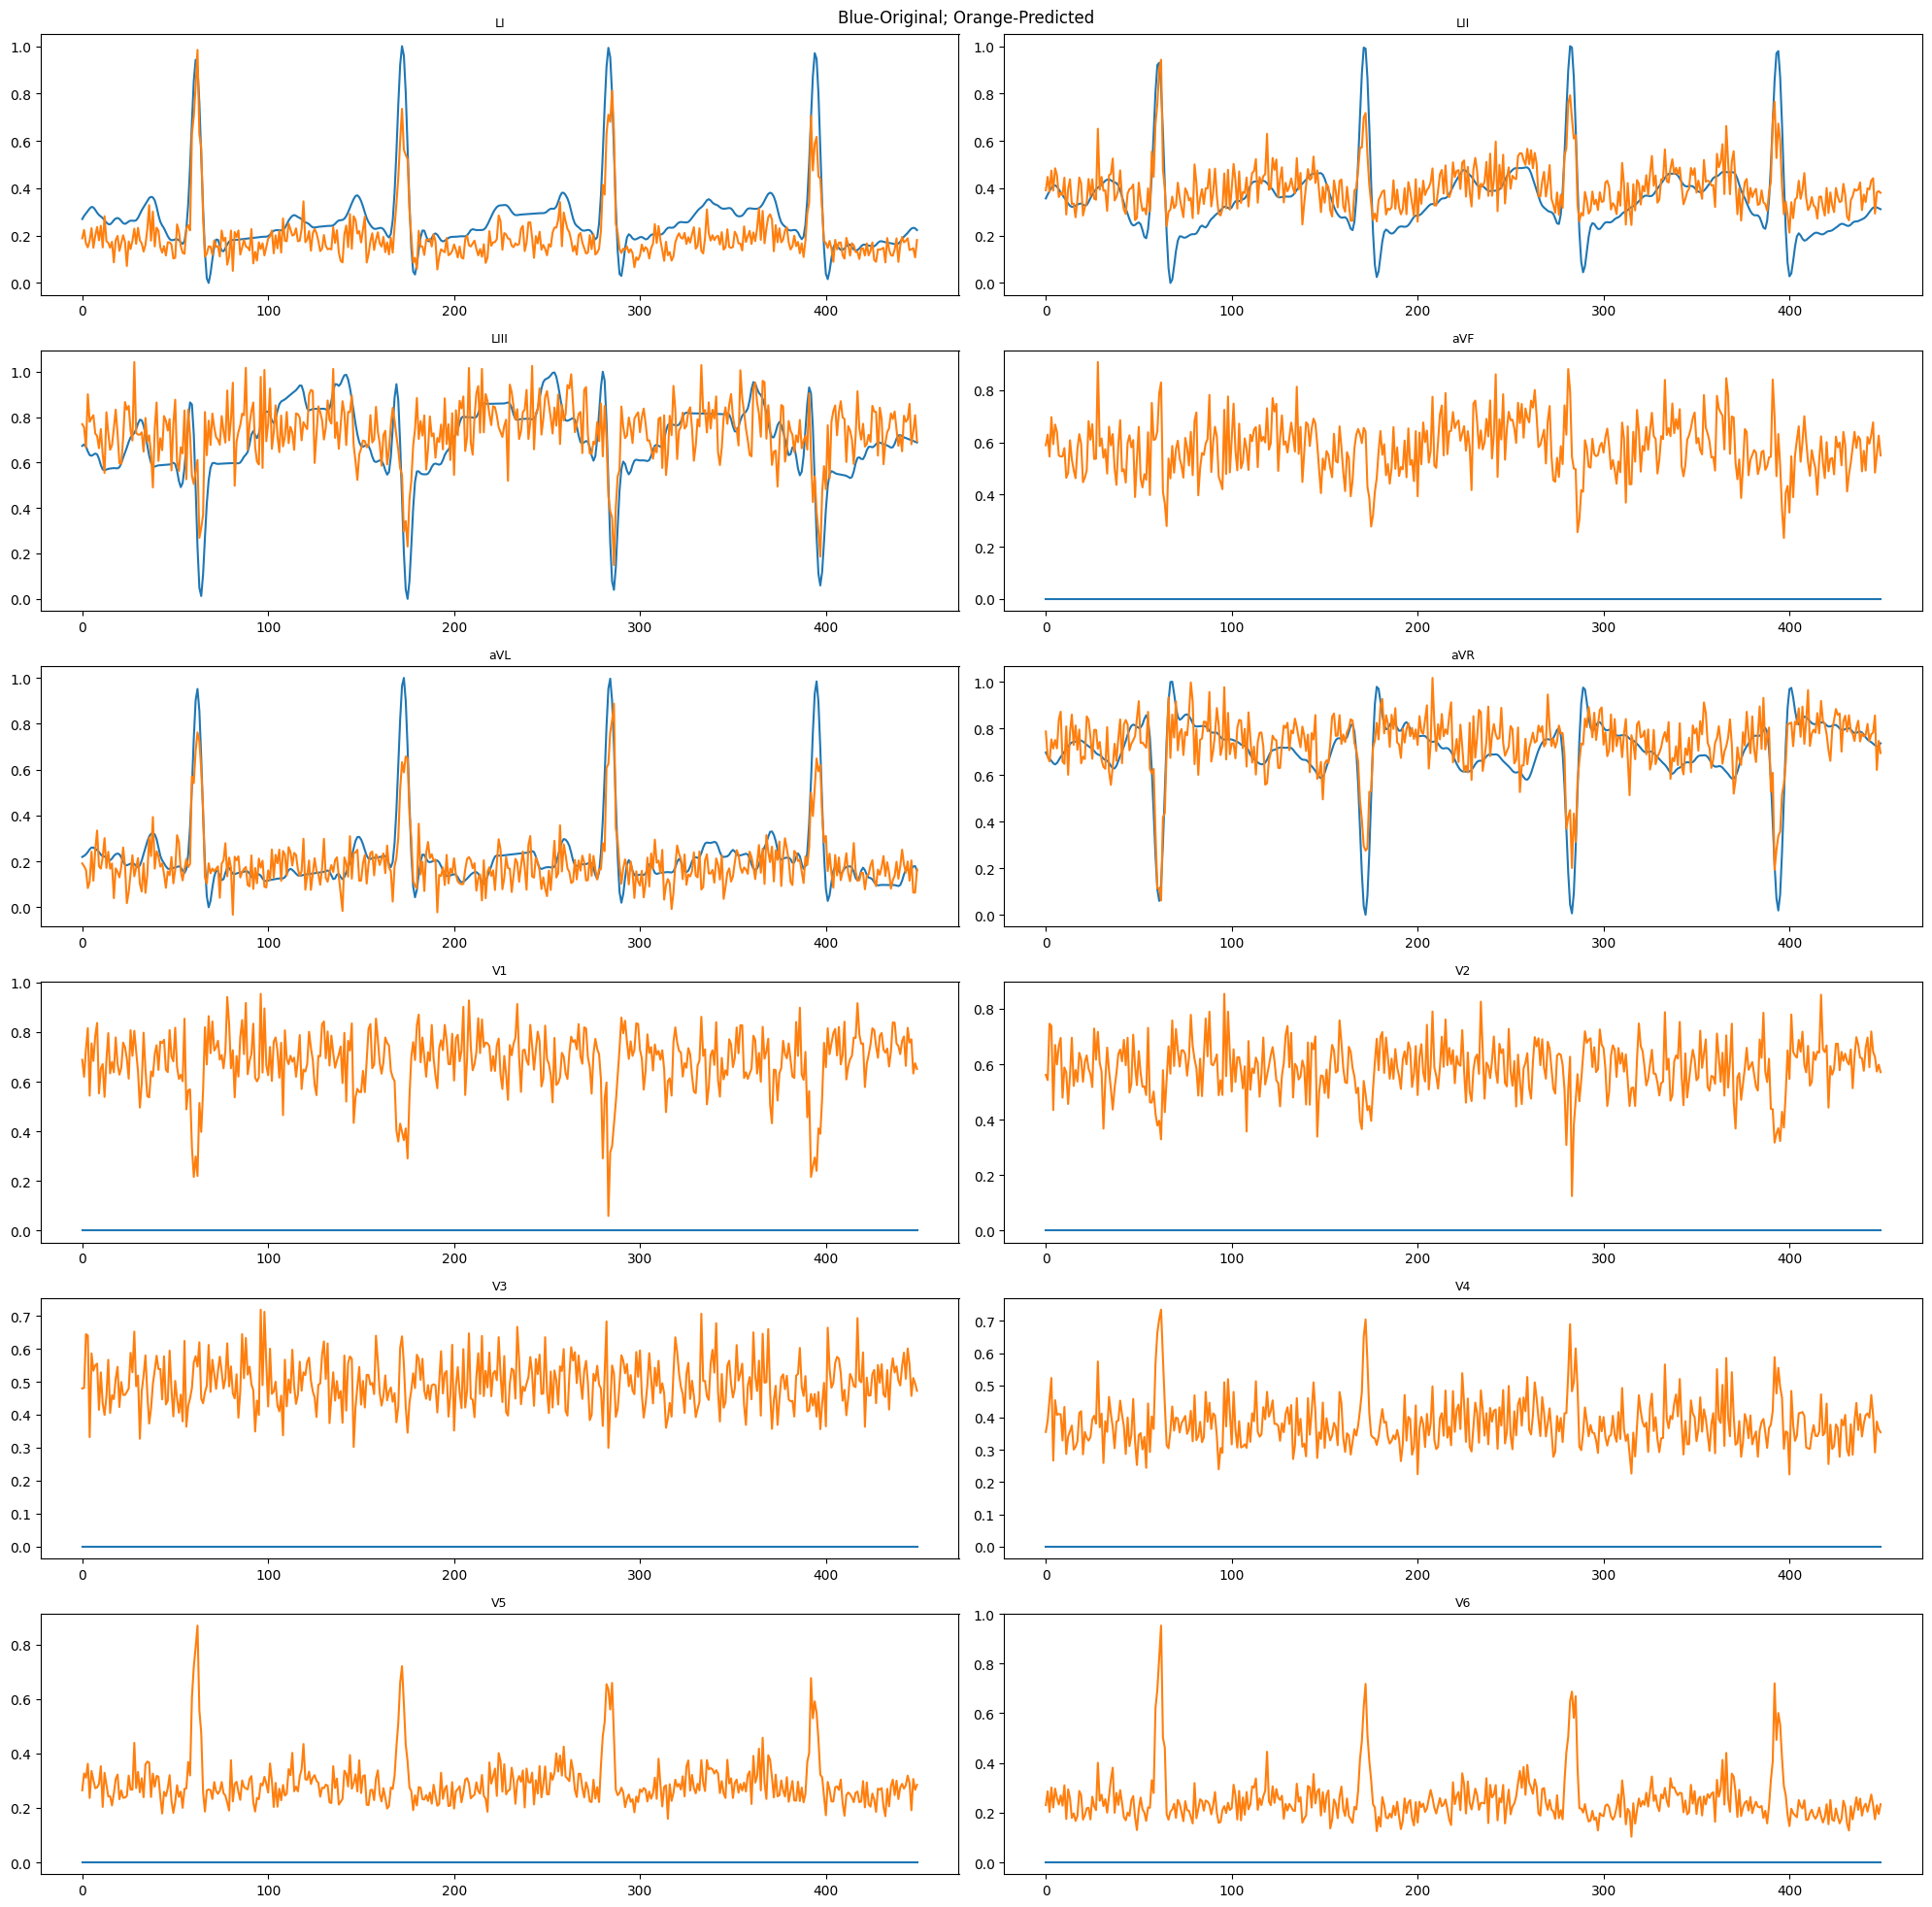

64 1


/opt/homebrew/Caskroom/miniforge/base/envs/torch-gpu/lib/python3.8/site-packages/torch/nn/modules/transformer.py:218: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because  self.layers[0].self_attn.batch_first was not True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


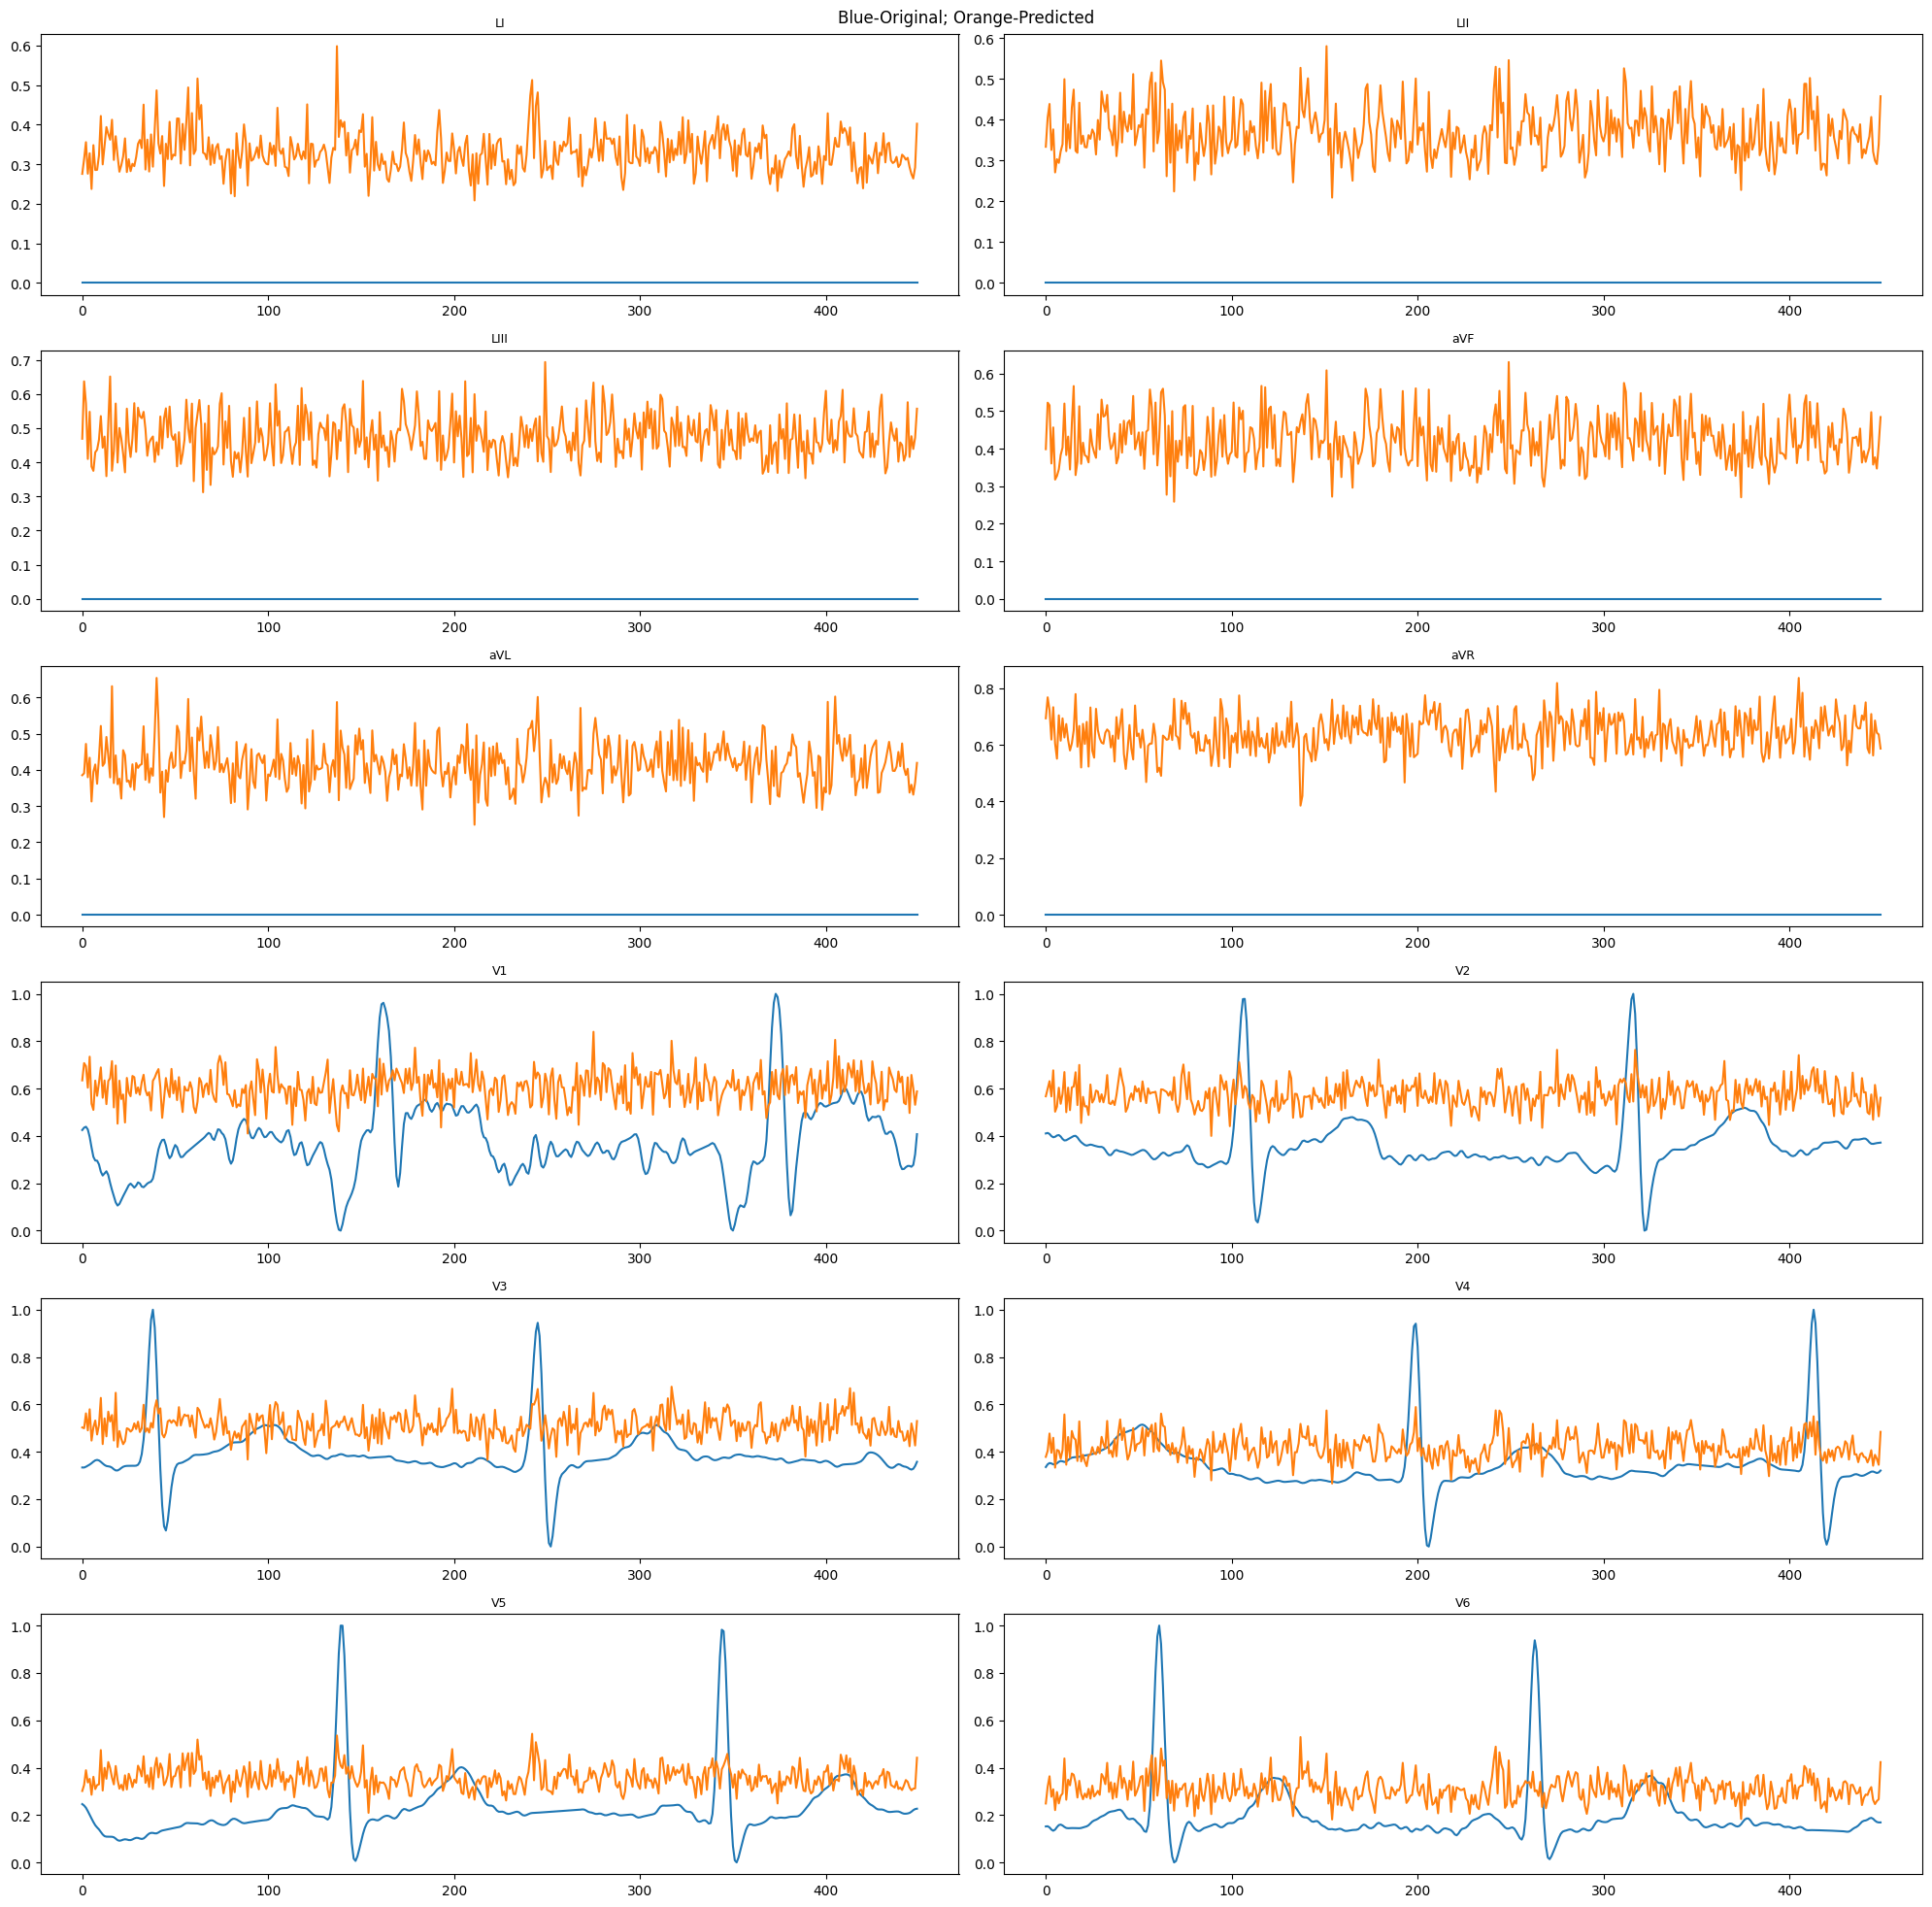

64 1


/opt/homebrew/Caskroom/miniforge/base/envs/torch-gpu/lib/python3.8/site-packages/torch/nn/modules/transformer.py:218: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because  self.layers[0].self_attn.batch_first was not True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


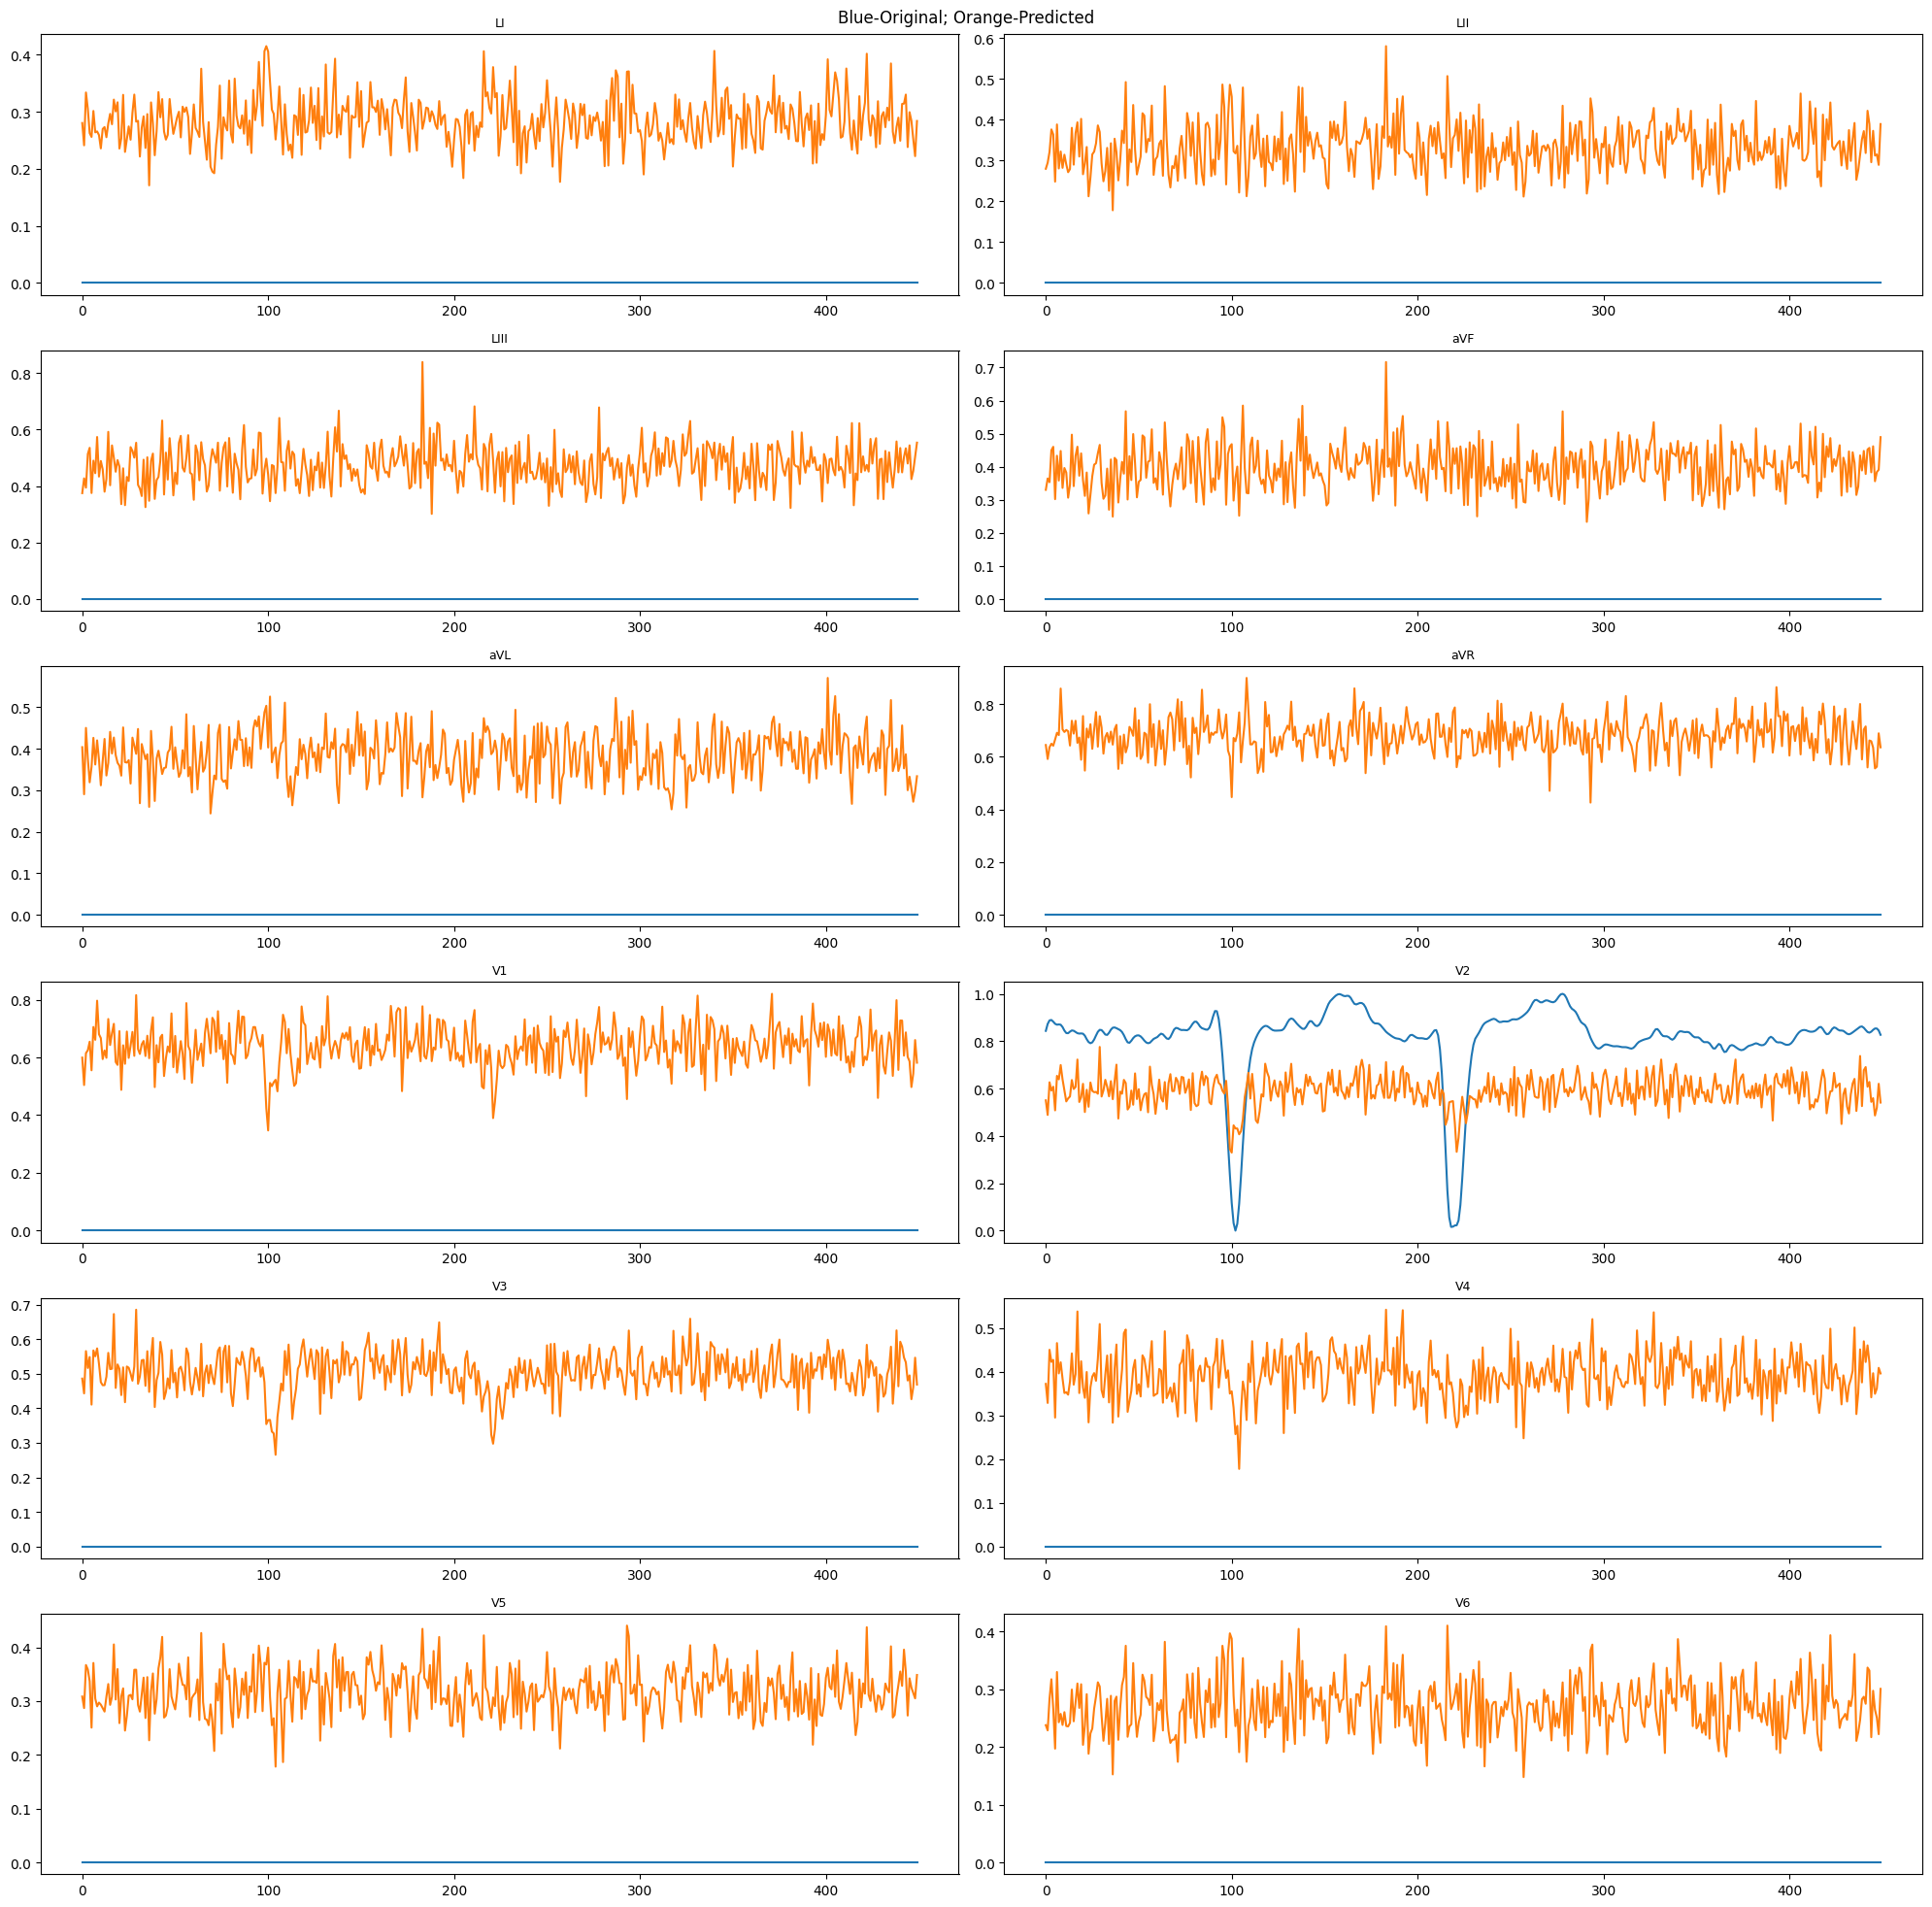

64 1


/opt/homebrew/Caskroom/miniforge/base/envs/torch-gpu/lib/python3.8/site-packages/torch/nn/modules/transformer.py:218: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because  self.layers[0].self_attn.batch_first was not True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


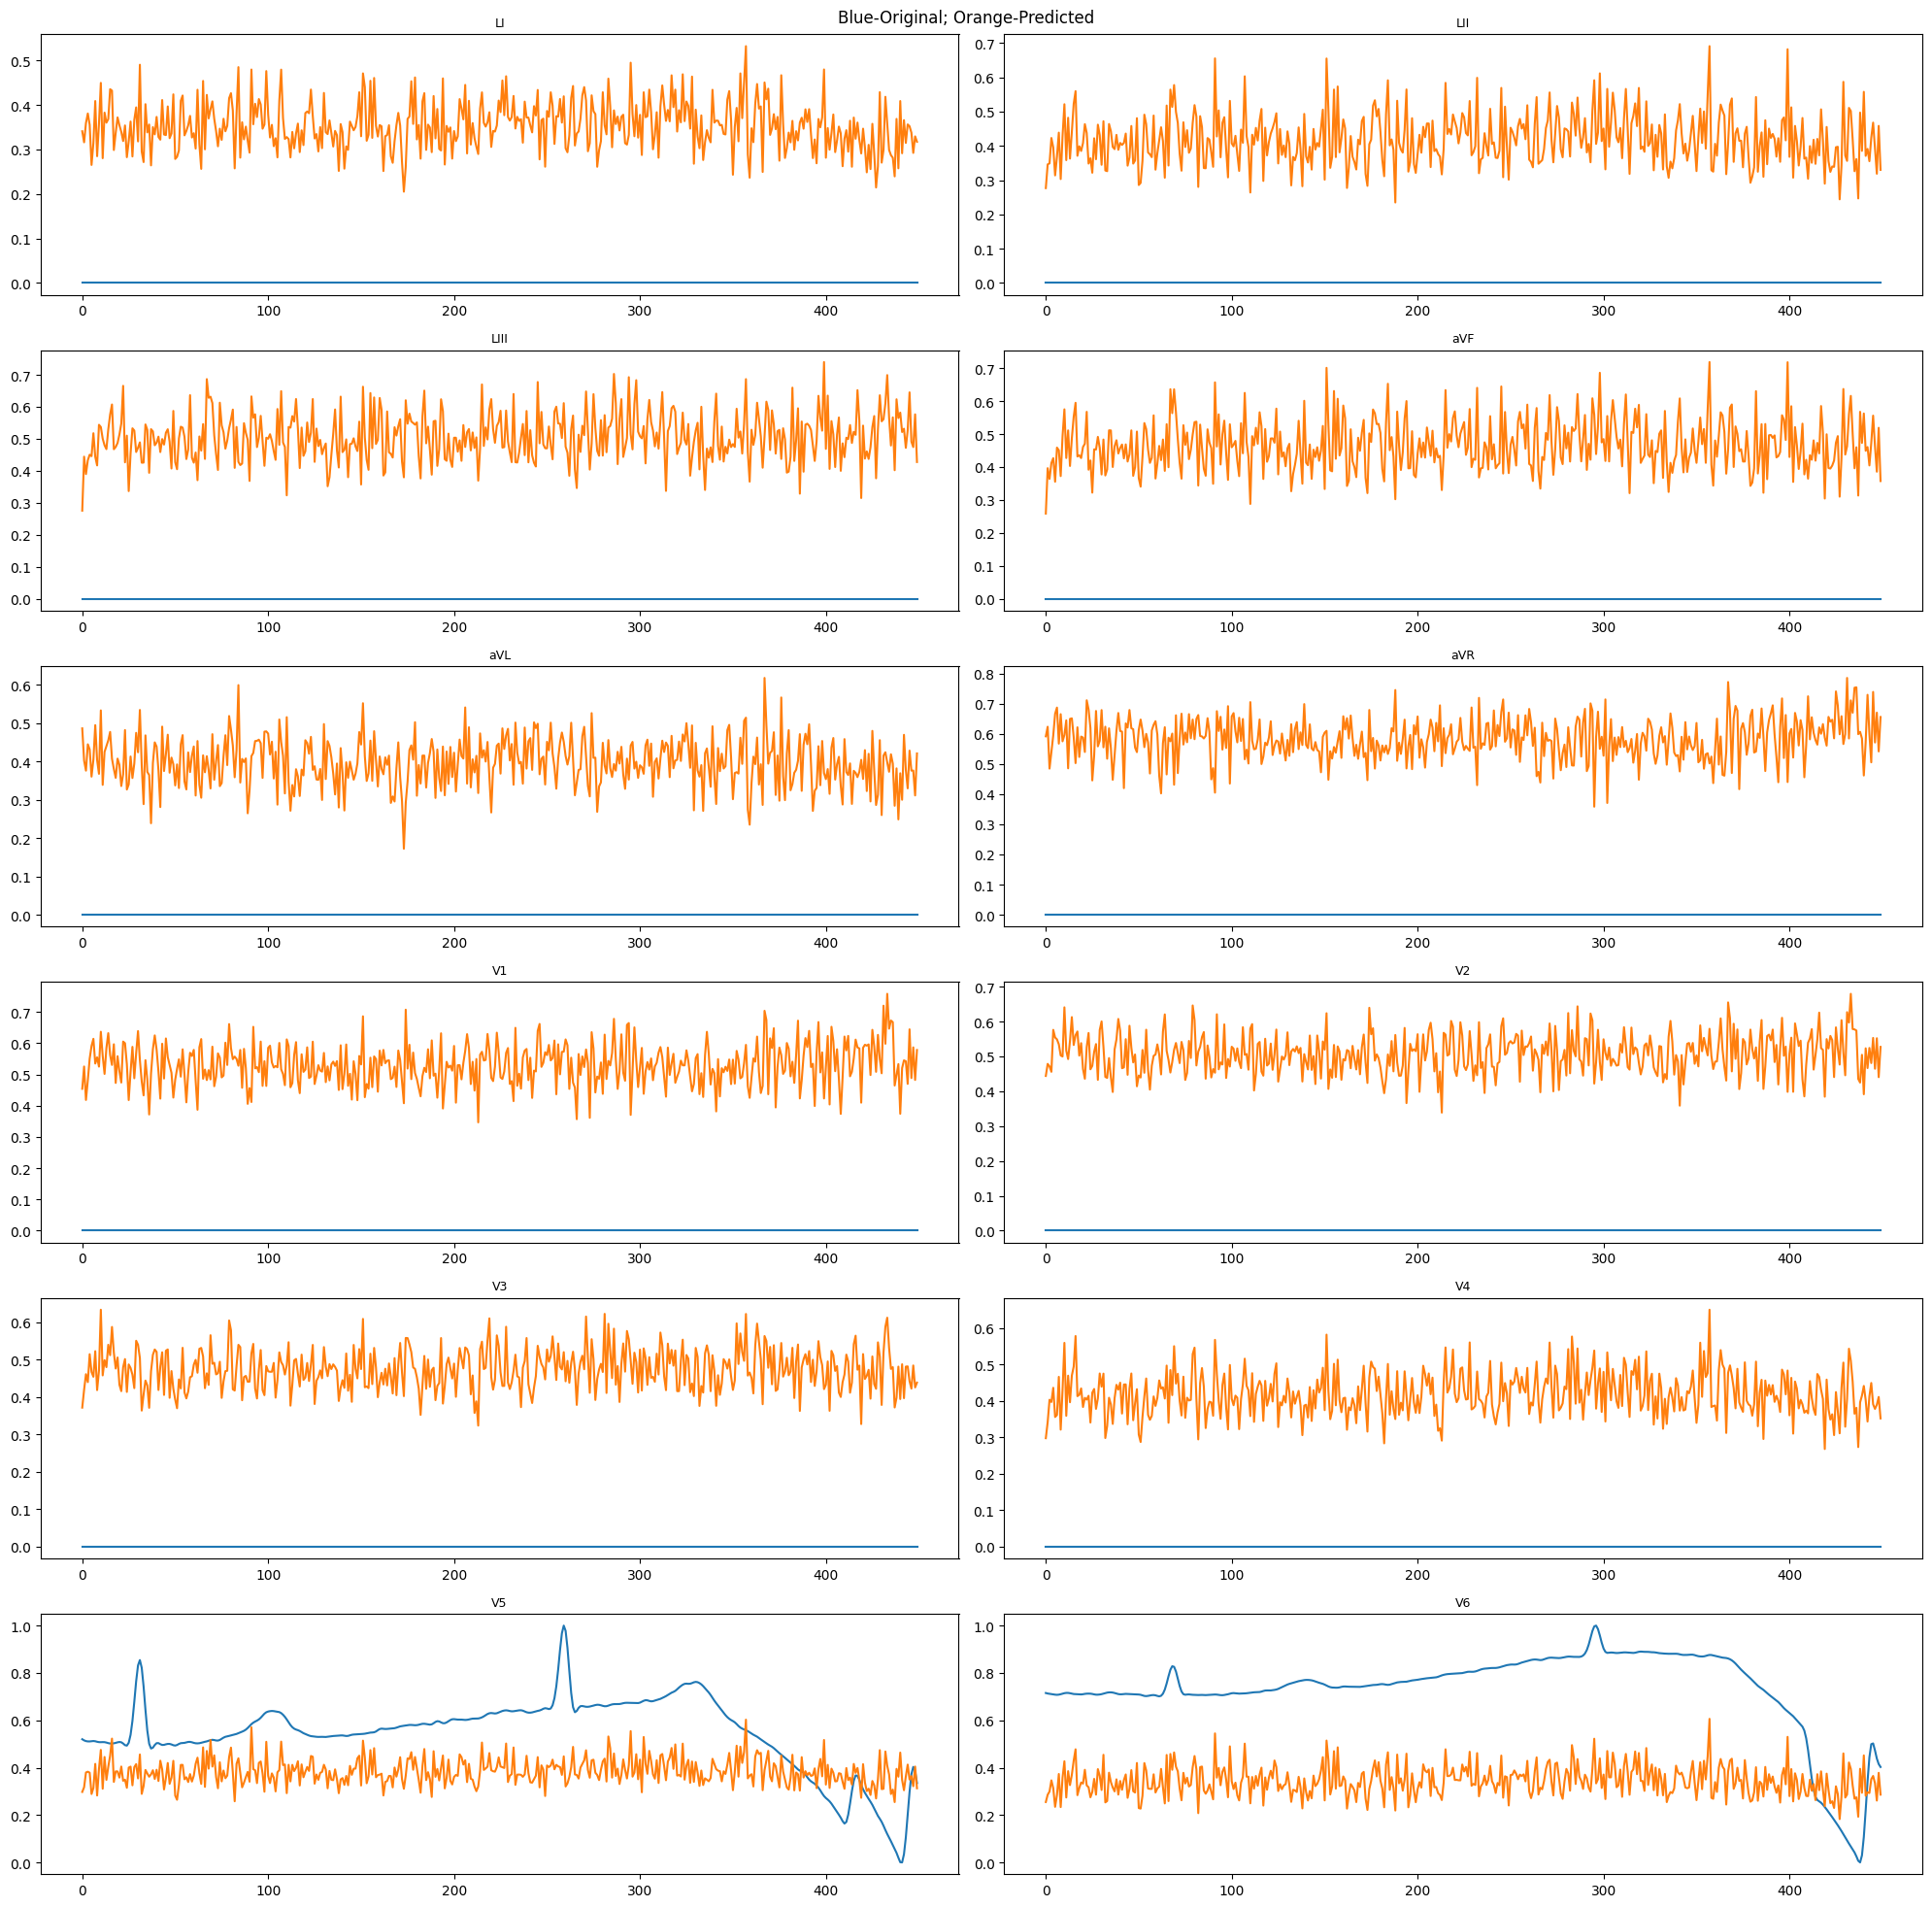

64 1


/opt/homebrew/Caskroom/miniforge/base/envs/torch-gpu/lib/python3.8/site-packages/torch/nn/modules/transformer.py:218: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because  self.layers[0].self_attn.batch_first was not True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


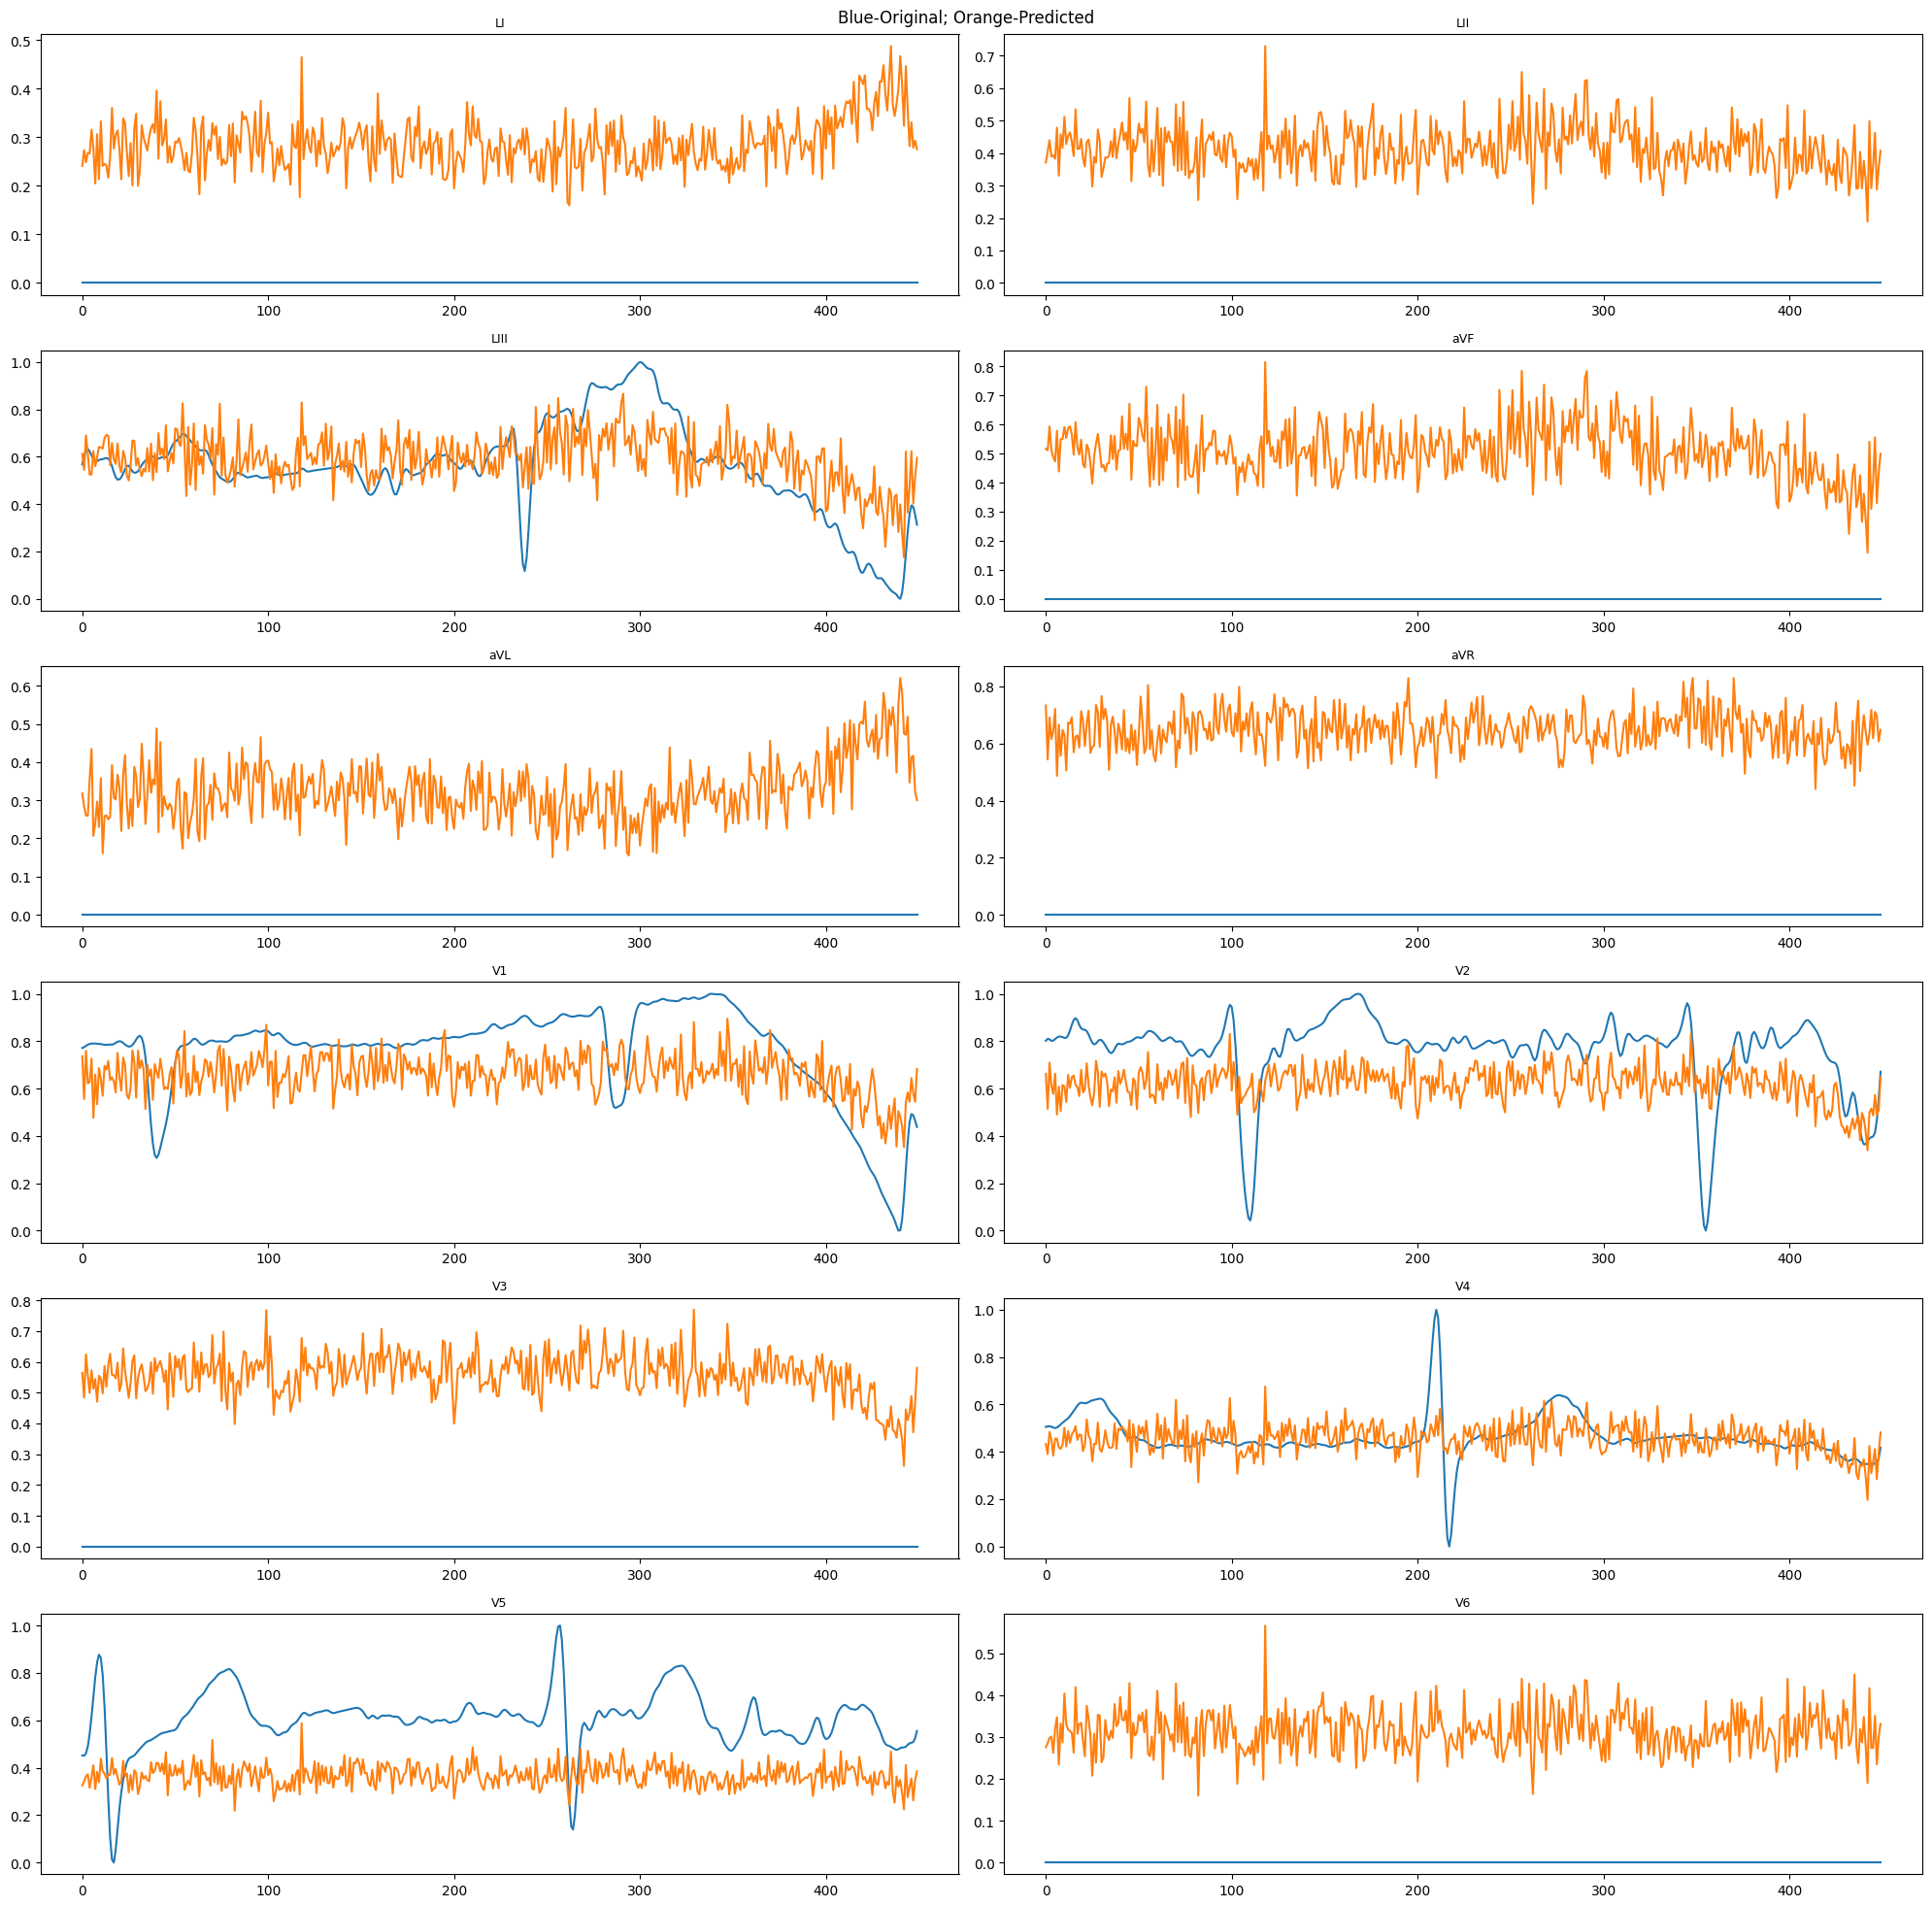

64 1


/opt/homebrew/Caskroom/miniforge/base/envs/torch-gpu/lib/python3.8/site-packages/torch/nn/modules/transformer.py:218: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because  self.layers[0].self_attn.batch_first was not True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


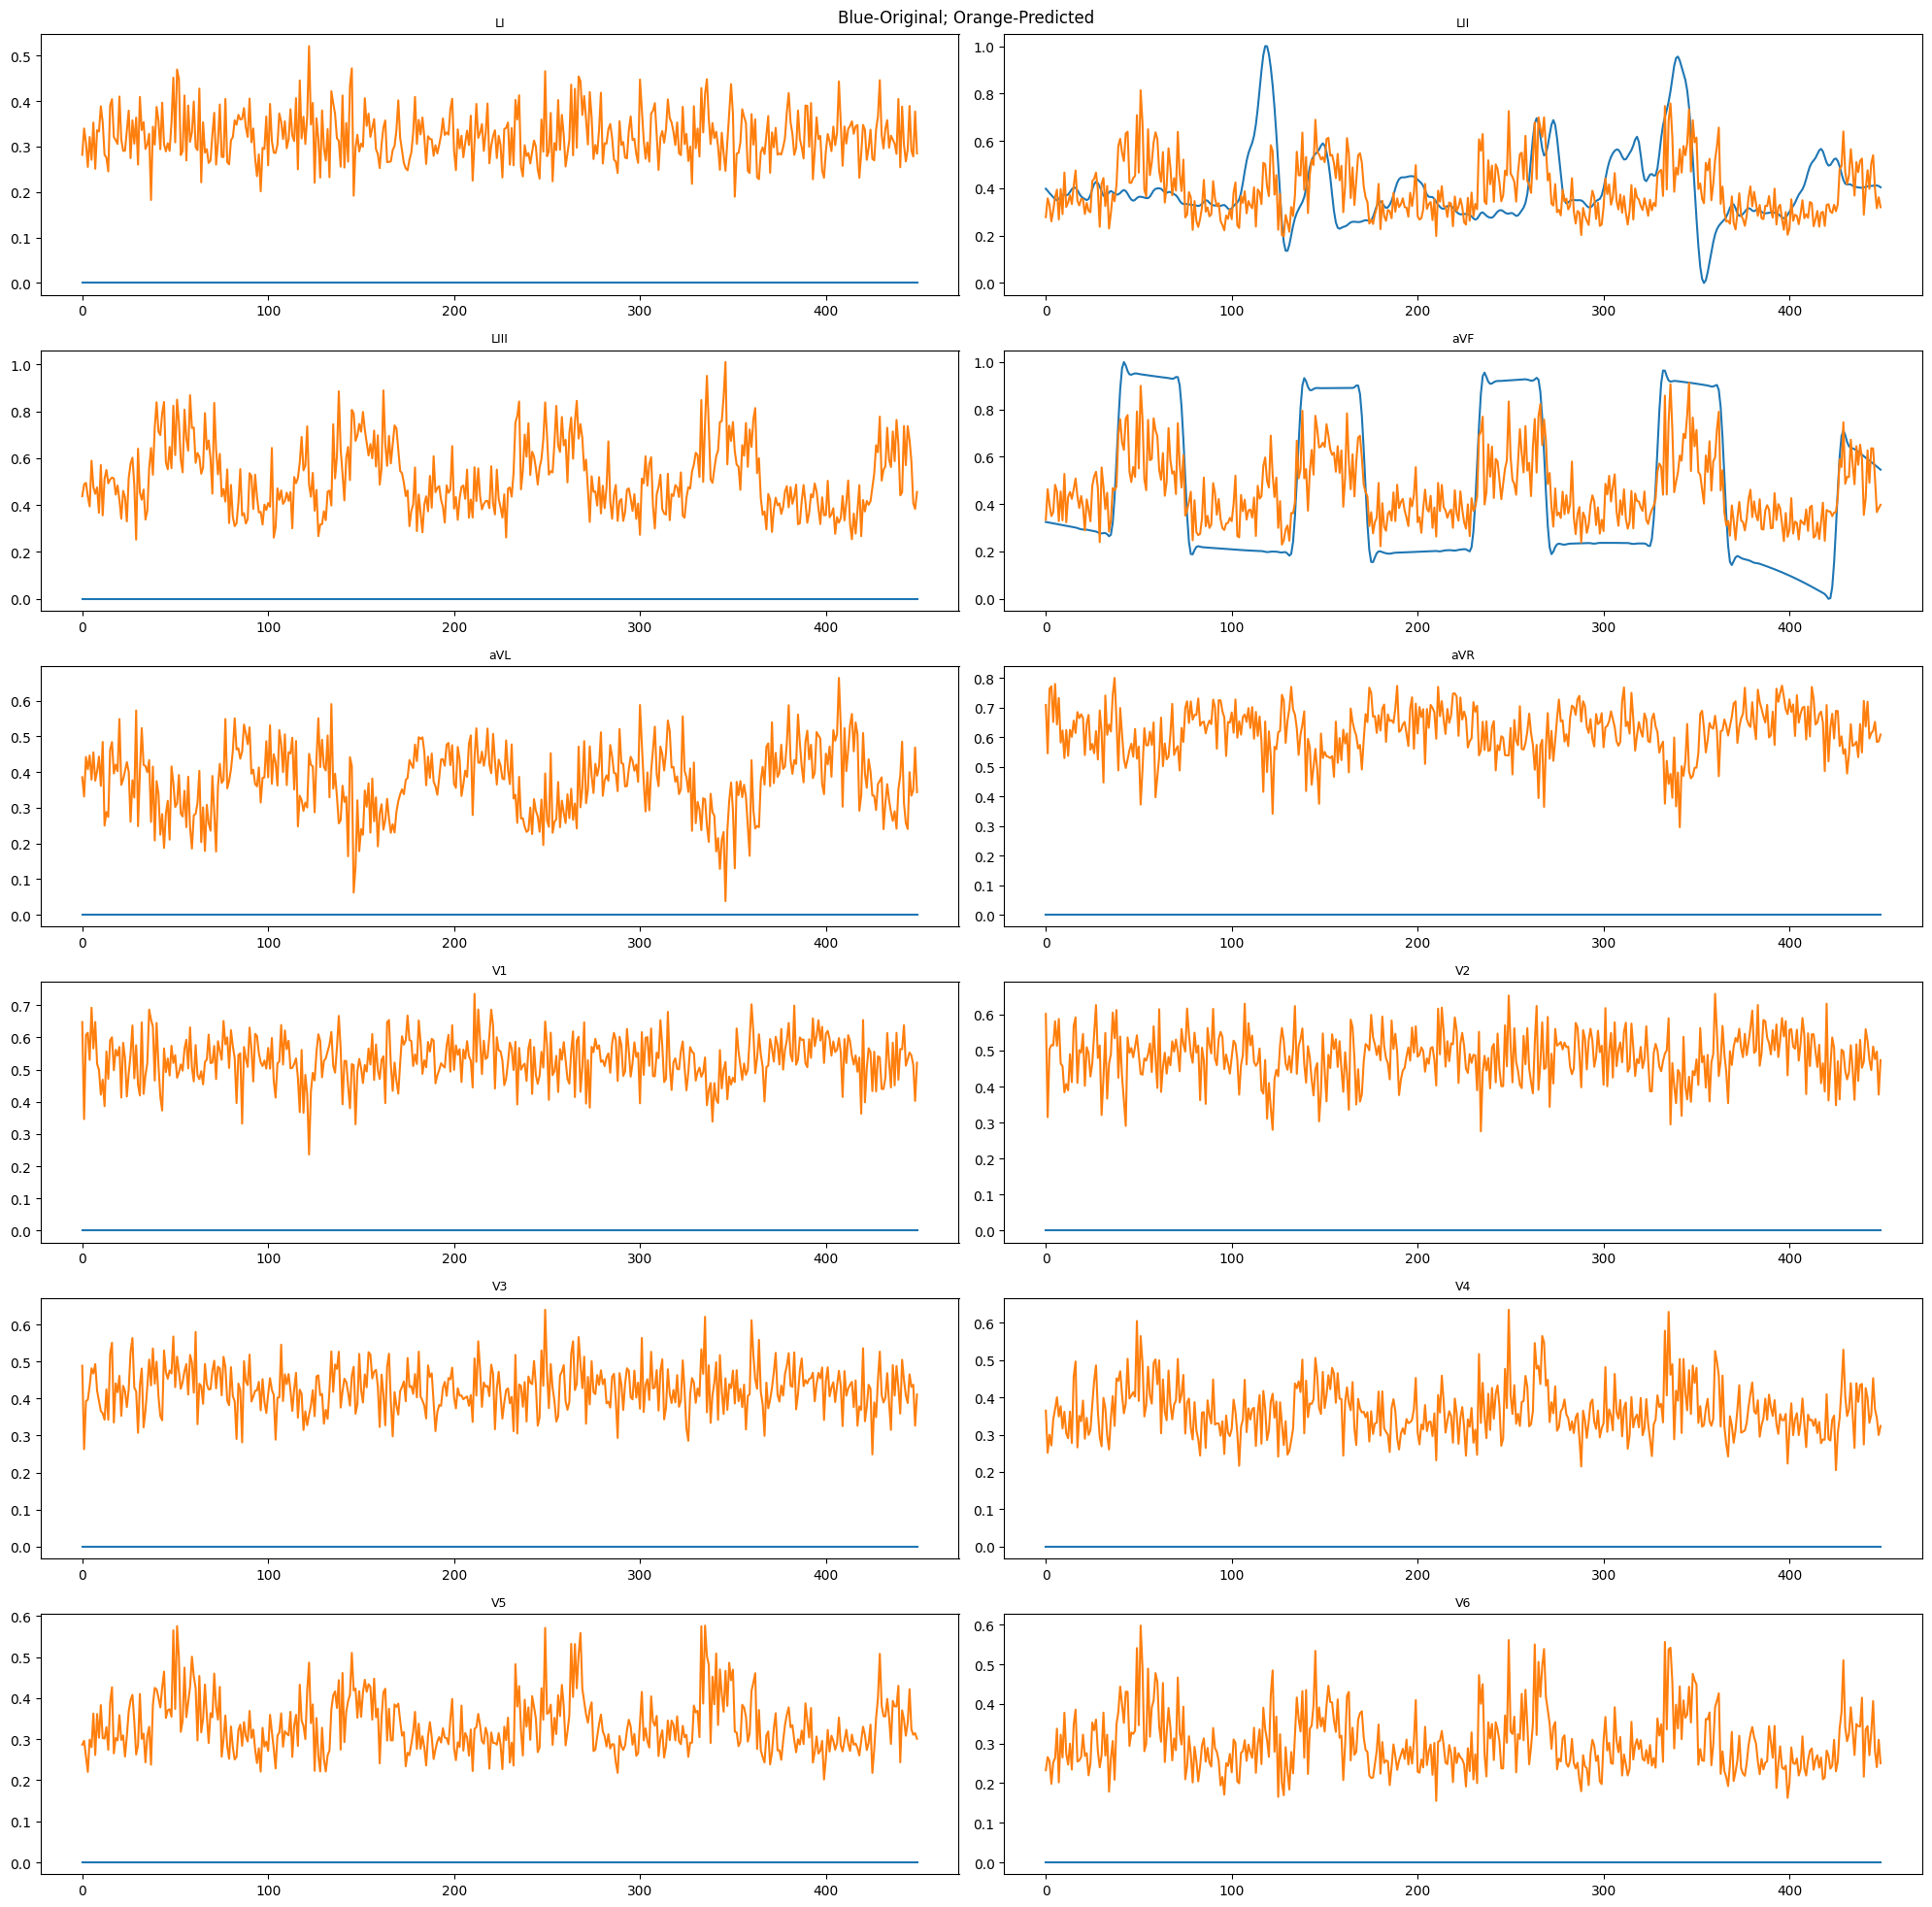

64 1


/opt/homebrew/Caskroom/miniforge/base/envs/torch-gpu/lib/python3.8/site-packages/torch/nn/modules/transformer.py:218: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because  self.layers[0].self_attn.batch_first was not True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


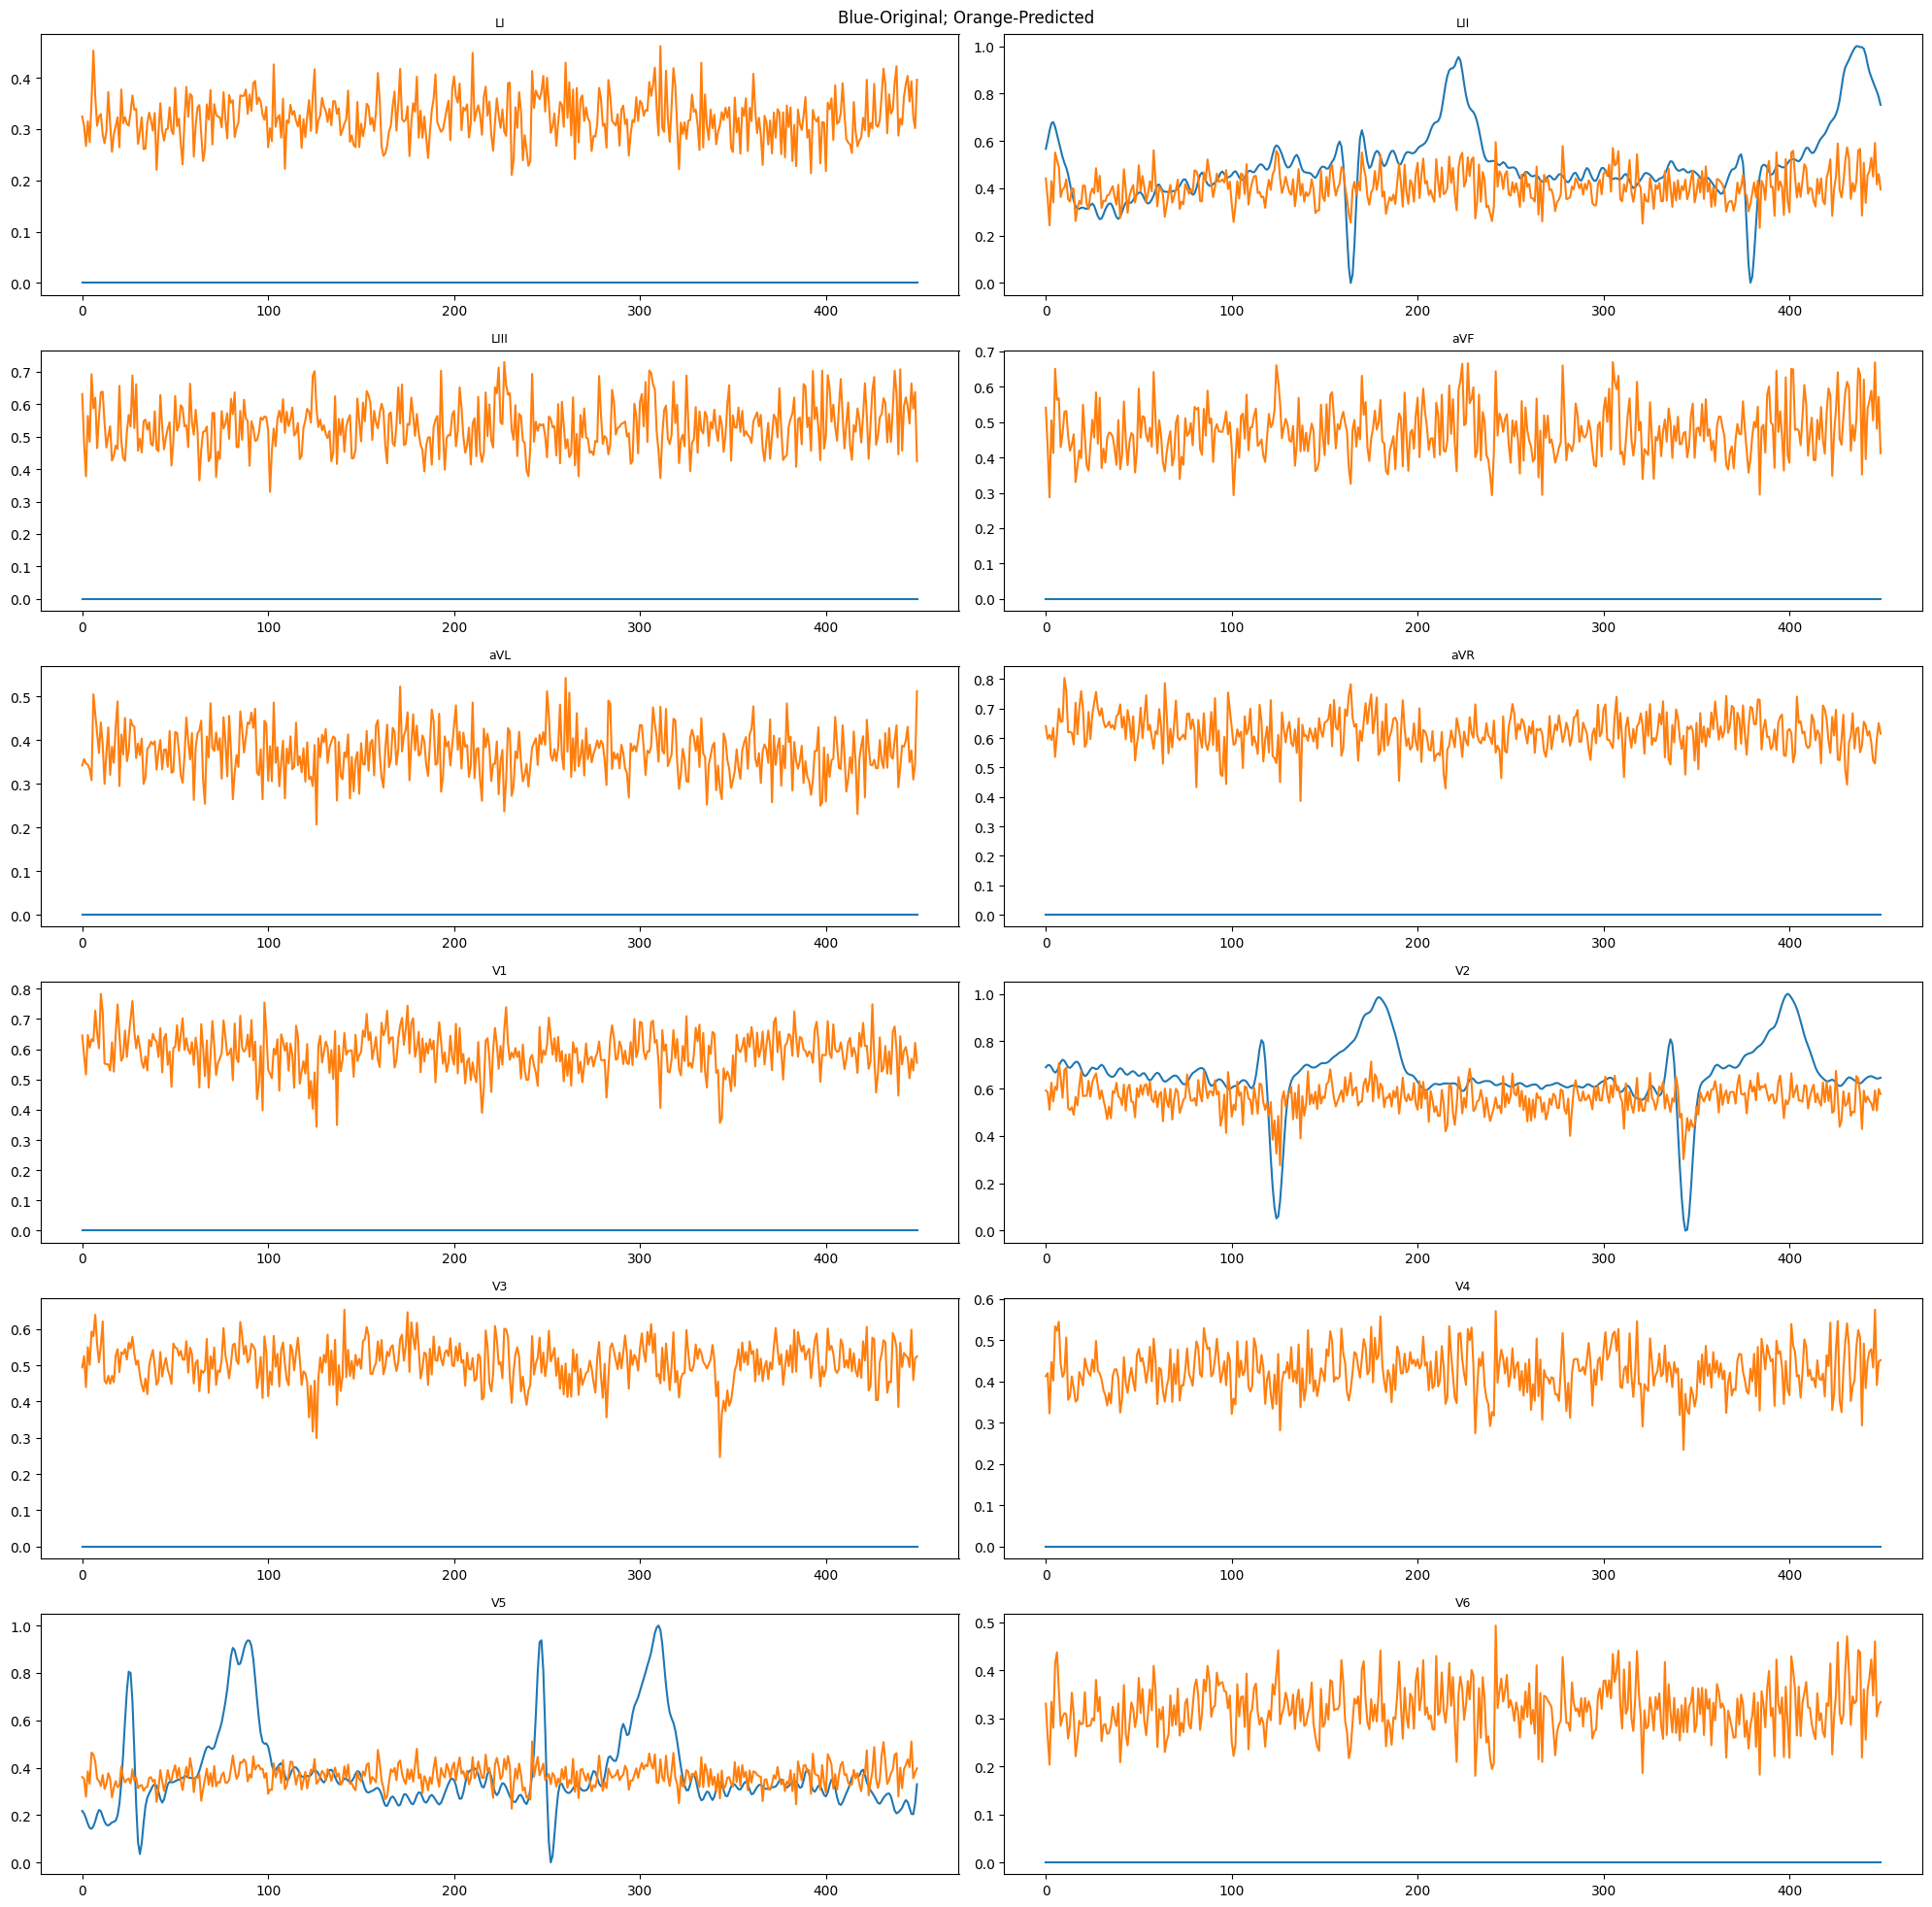

64 1


/opt/homebrew/Caskroom/miniforge/base/envs/torch-gpu/lib/python3.8/site-packages/torch/nn/modules/transformer.py:218: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because  self.layers[0].self_attn.batch_first was not True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


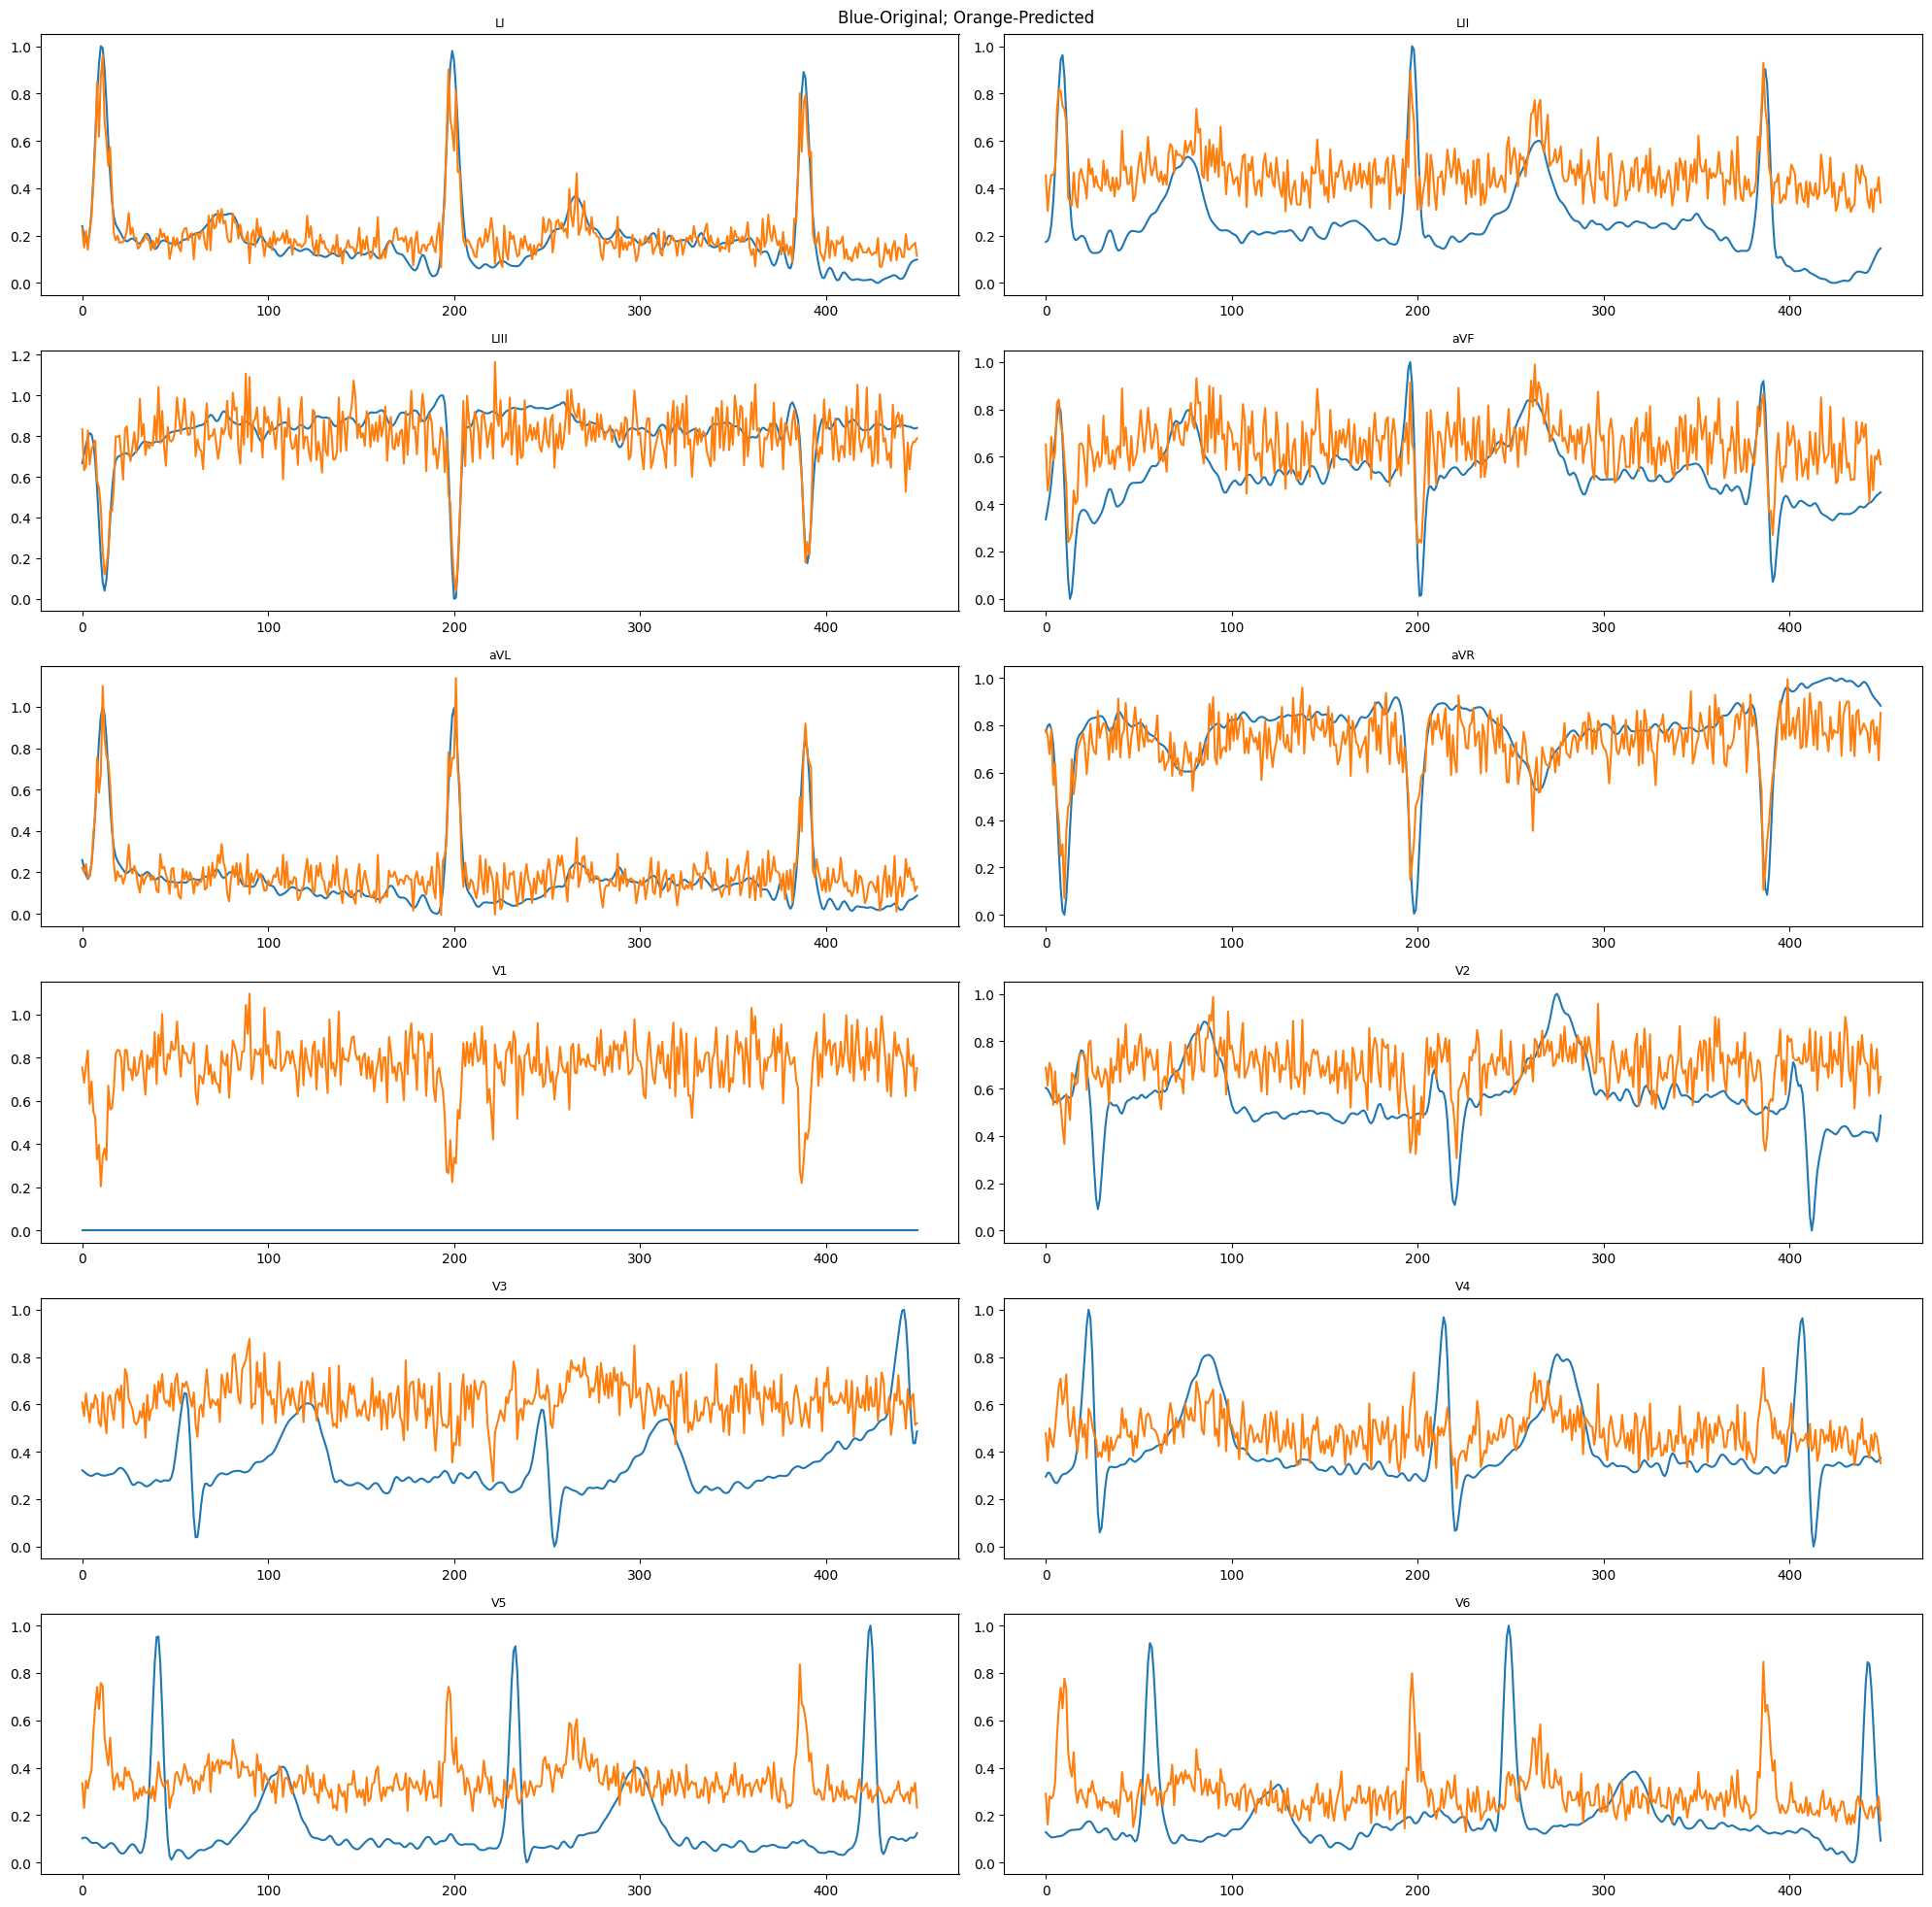

64 1


/opt/homebrew/Caskroom/miniforge/base/envs/torch-gpu/lib/python3.8/site-packages/torch/nn/modules/transformer.py:218: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because  self.layers[0].self_attn.batch_first was not True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


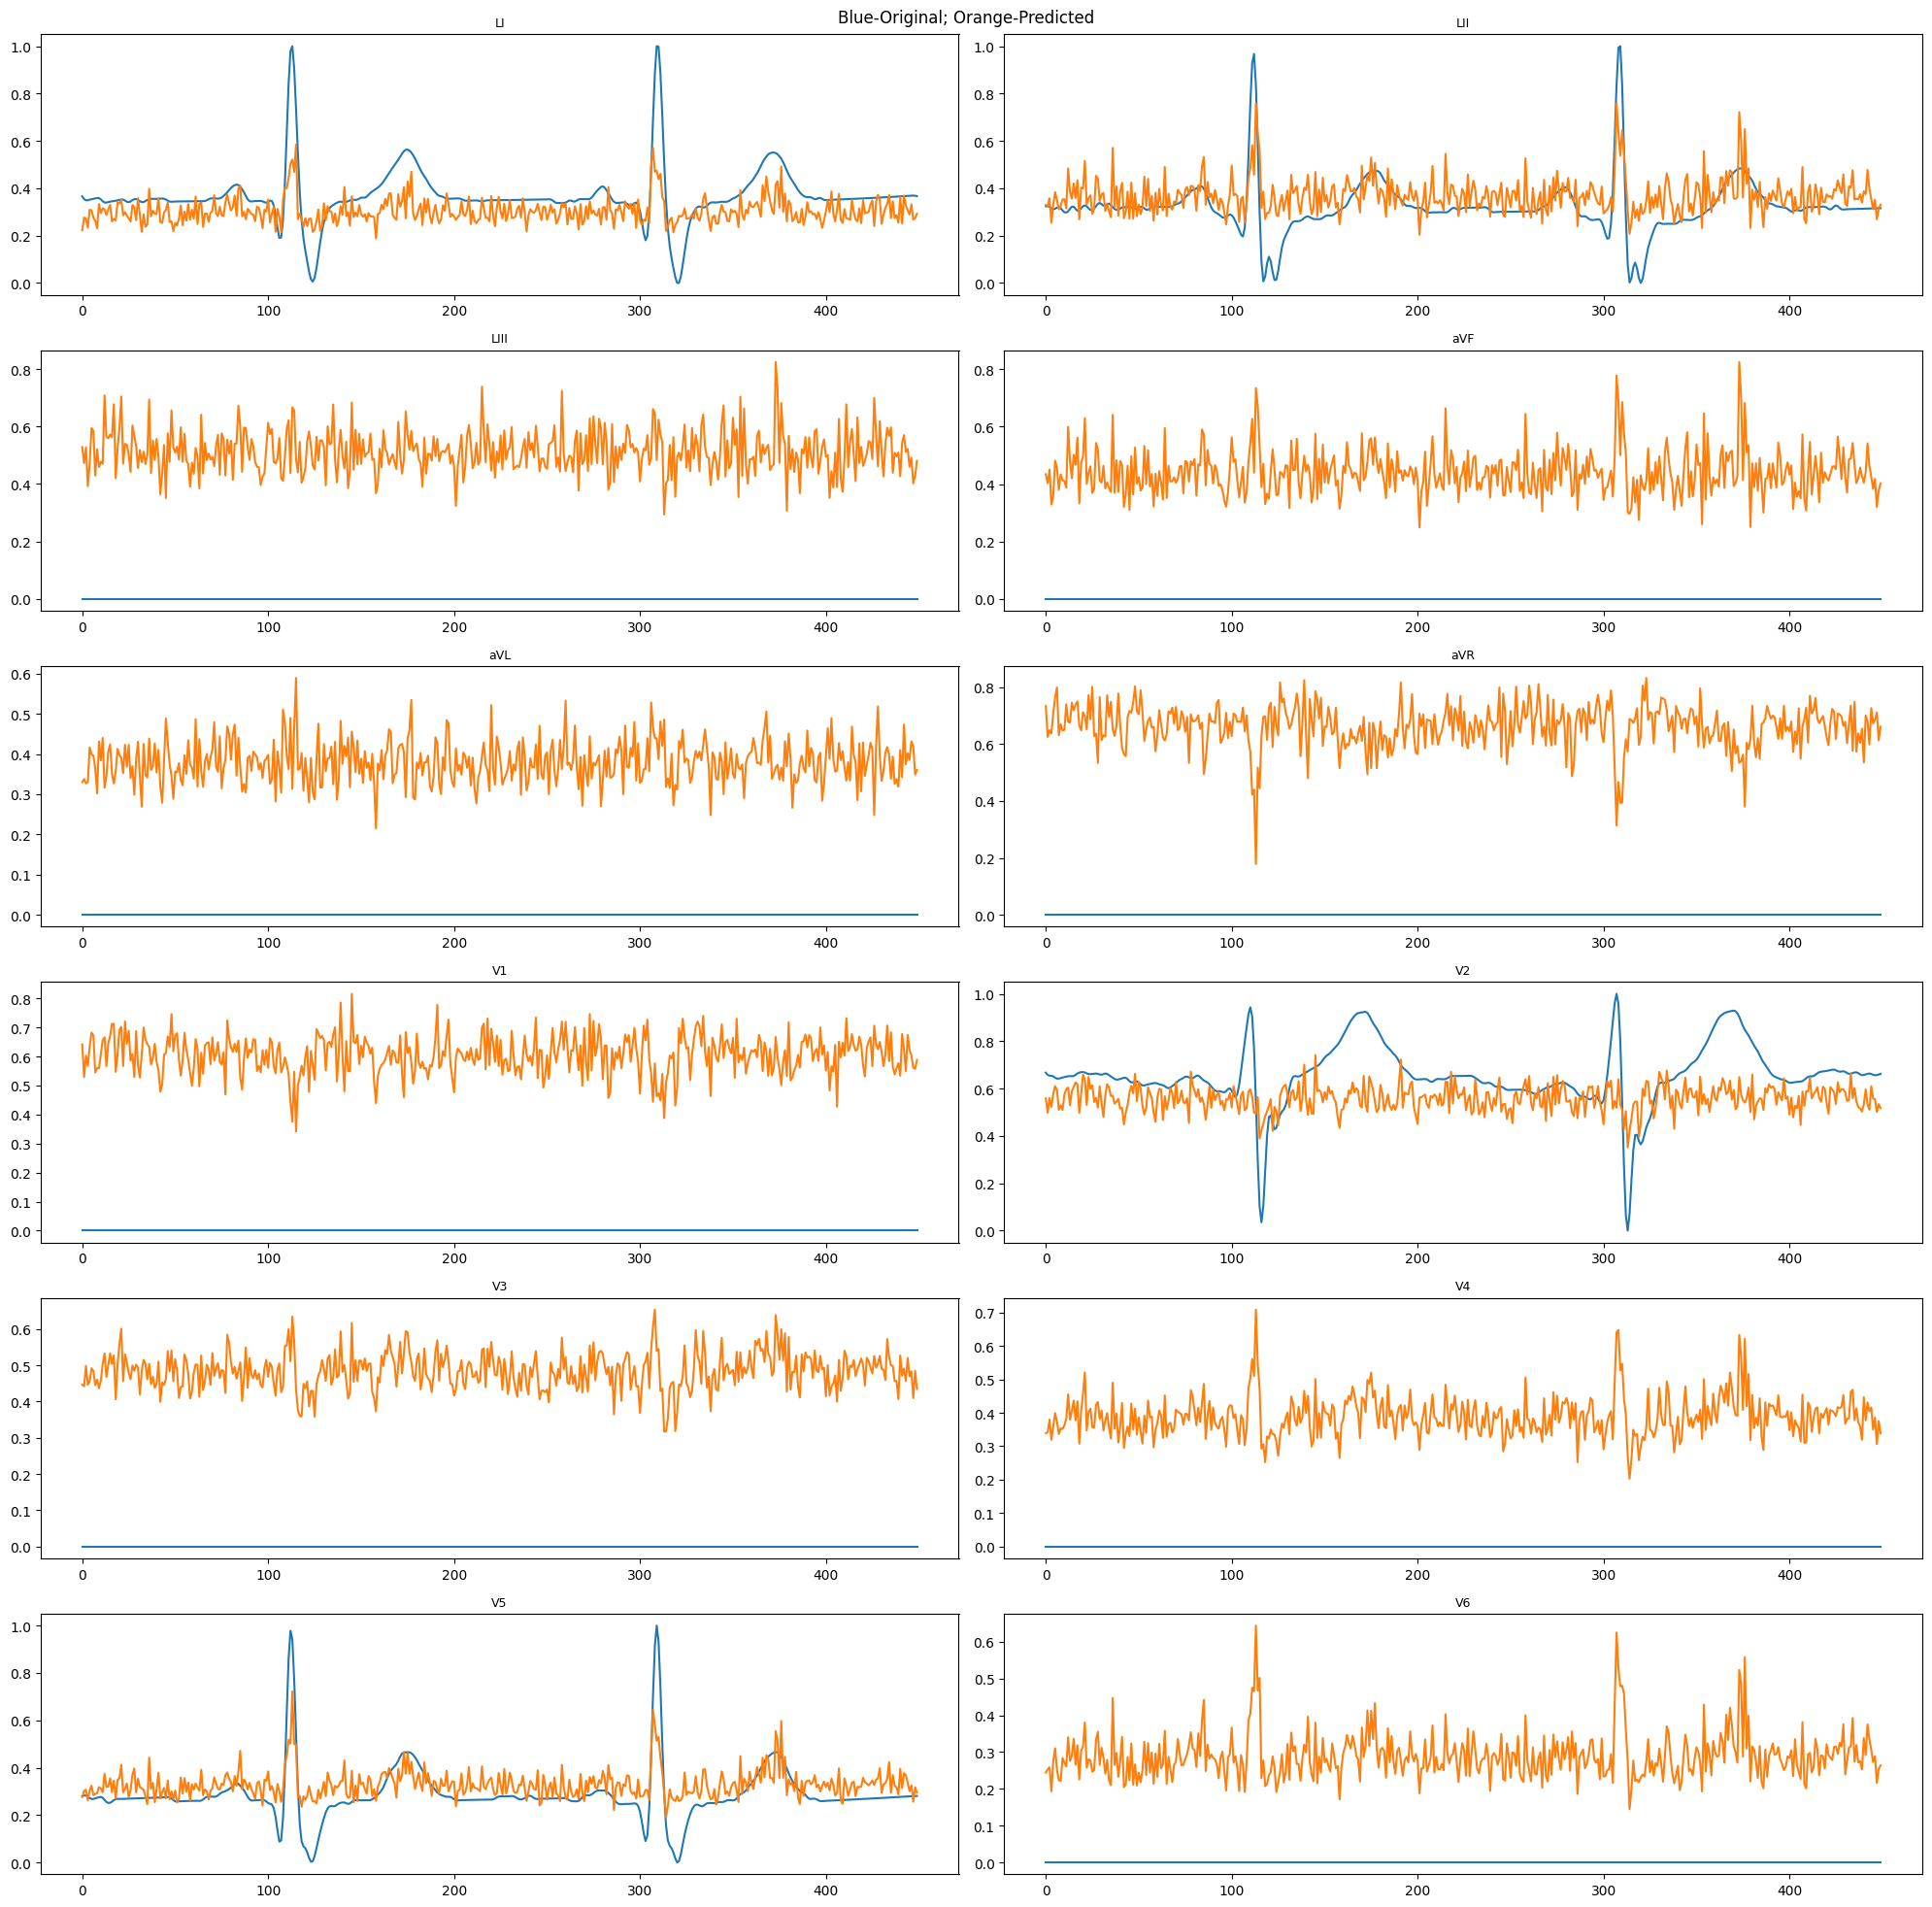

64 1


/opt/homebrew/Caskroom/miniforge/base/envs/torch-gpu/lib/python3.8/site-packages/torch/nn/modules/transformer.py:218: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because  self.layers[0].self_attn.batch_first was not True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


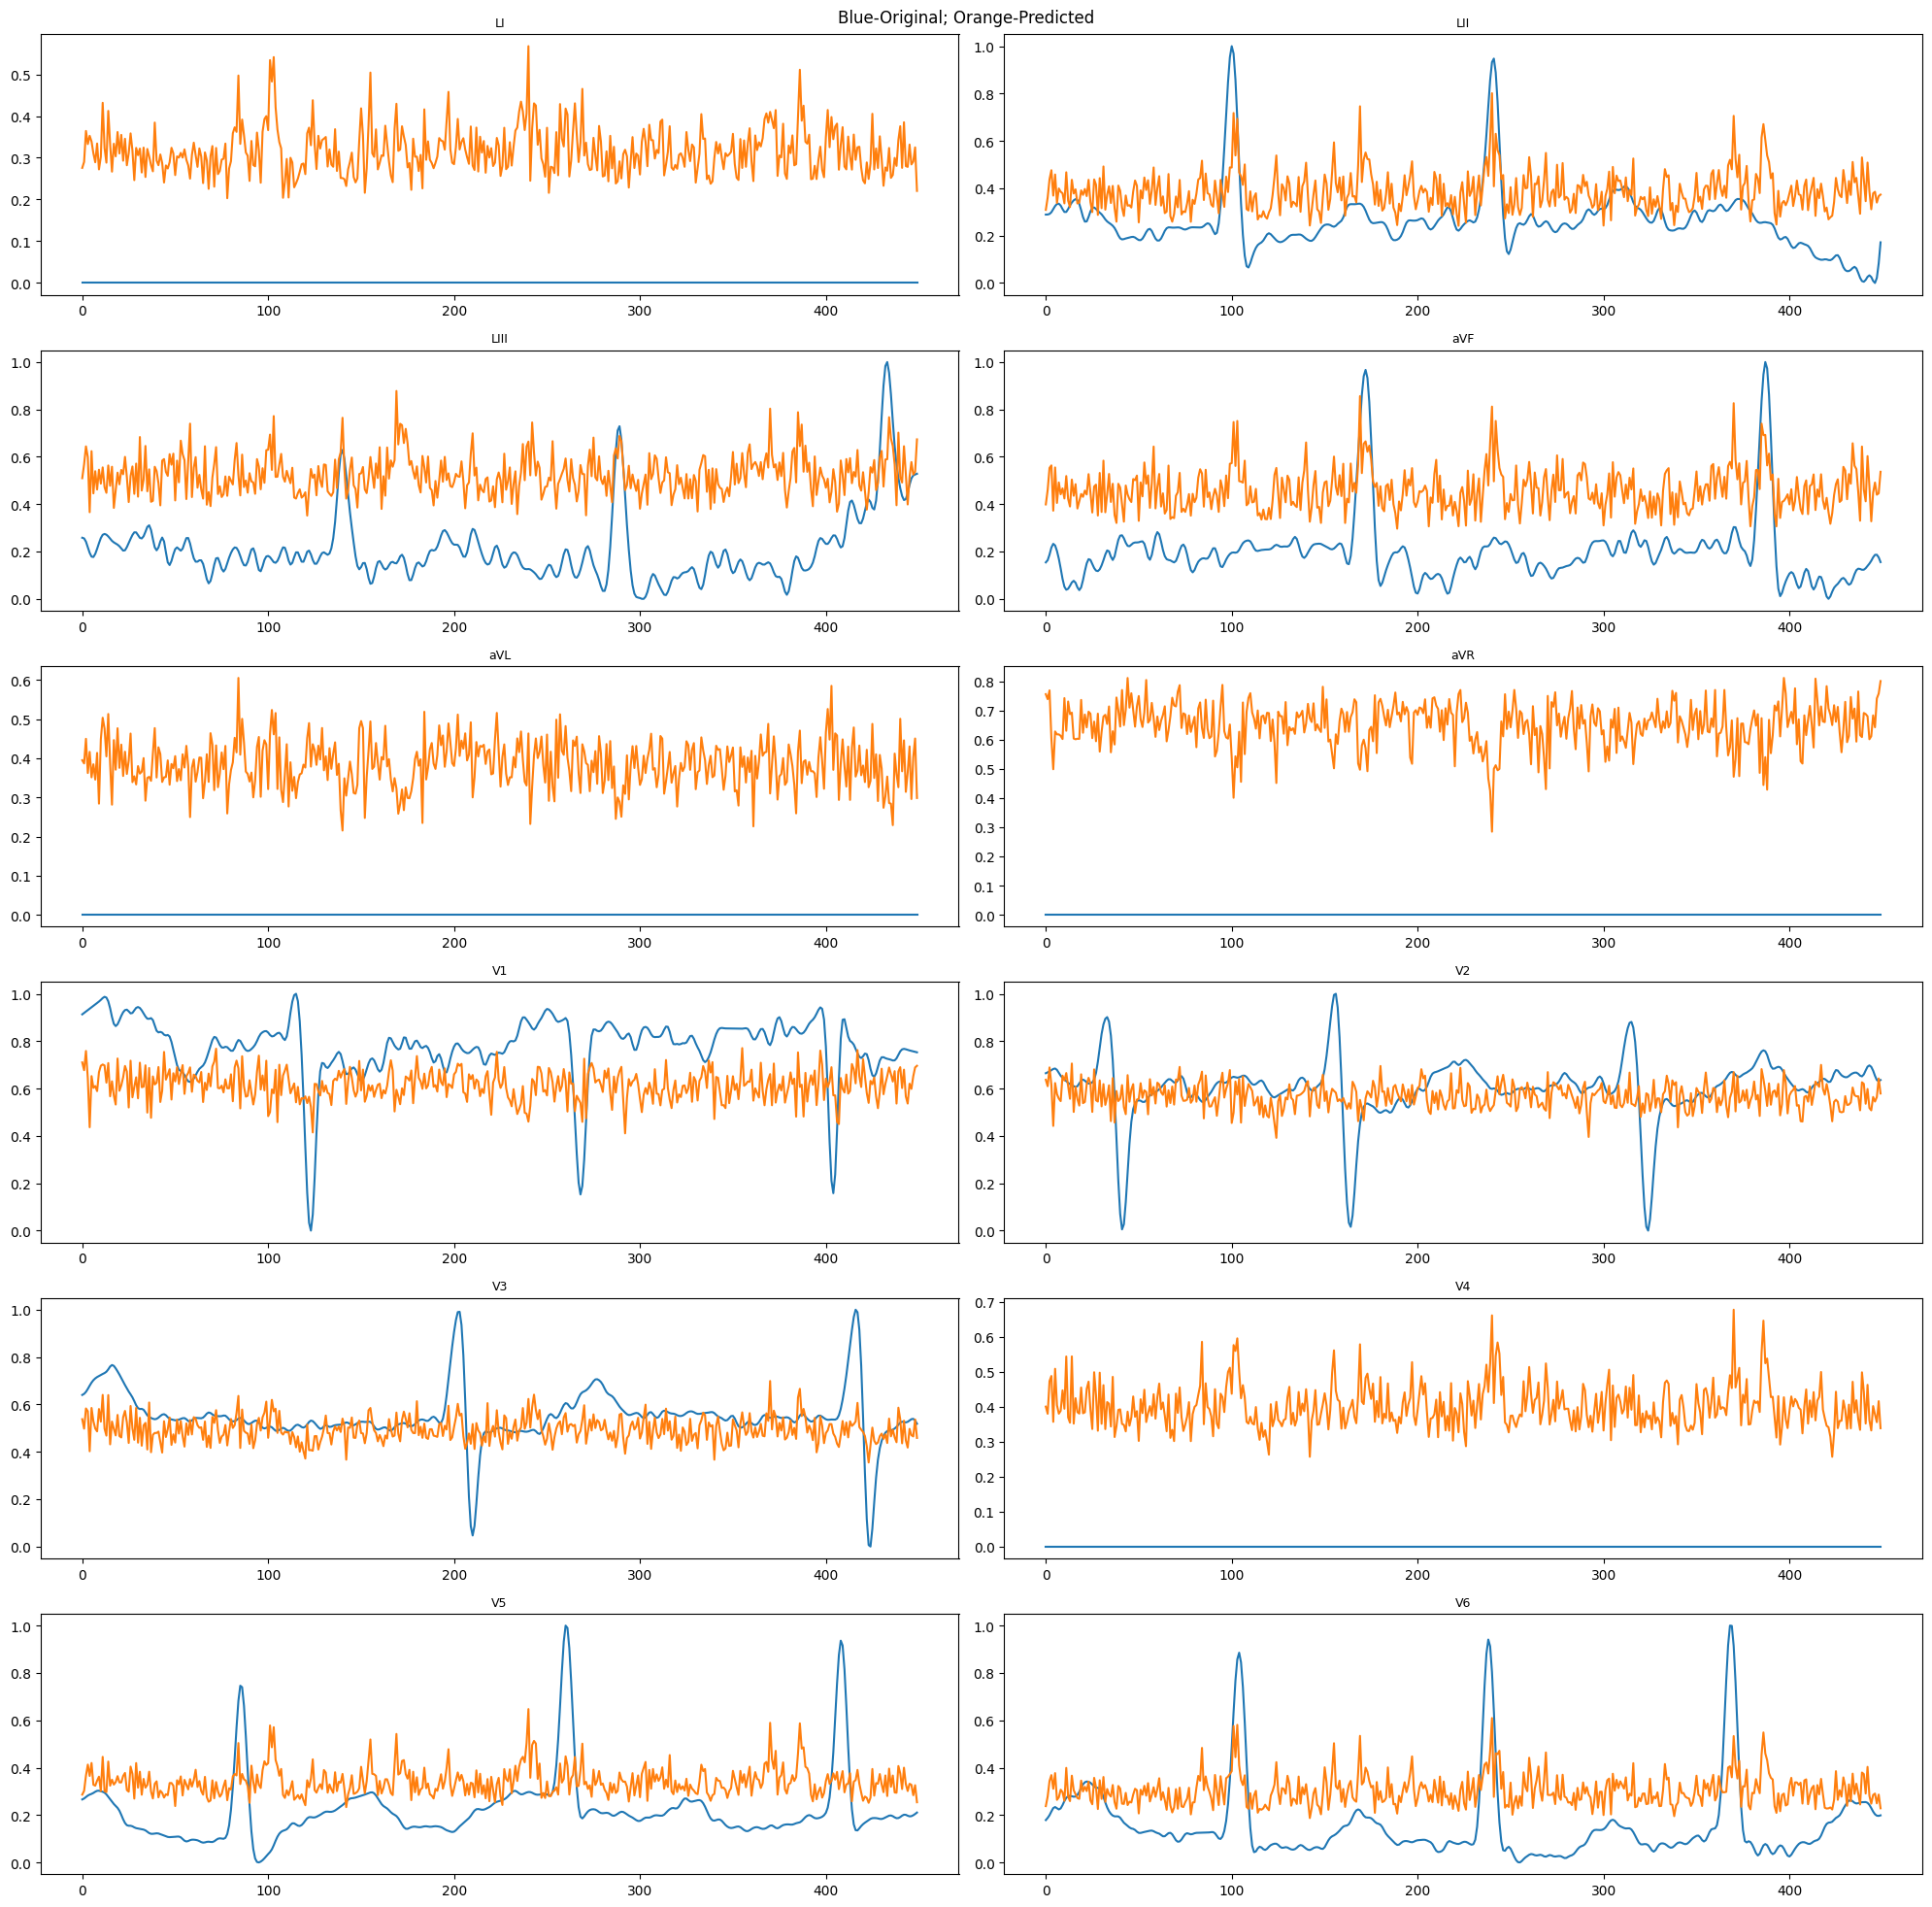

In [21]:
for _ in range(10):
    S = np.random.randint(0,1000,1)[0]
    src_,signal_names = train_generator.__getitem__(S)
    src_ = np.float32(np.transpose(src_, axes=(2,0,1)))

    # move to gpu so we can pass through model
    src_ = torch.from_numpy(src_).to(device)

    # choose which signal from the first batch to look at
    batch_size = X1.shape[0]
    sig_to_plot = np.random.randint(0,batch_size,1)

    # predict
    model = TSTransformerEncoder(input_dimension, output_dimension, 
                        hidden_dimmension, attention_heads, 
                        decoder_number_of_layers, positional_encodings,dropout).to(device)
    model.load_state_dict(torch.load('/Users/davidharar/Documents/School/thesis/upstream_seq2seq/models/exp4-base-version-with-train-by-sample-window-450.pt'))
    
    with torch.no_grad():
        y_pred = model(src_,None).cpu().numpy()

    # prep signals for presentation
    corrupted = np.squeeze(src_[:,sig_to_plot,:].cpu().numpy()).T
    reconstructed = np.squeeze(y_pred[:,sig_to_plot,:]).T

    plot_12_signals_of_three_sources(corrupted,reconstructed, None)



In [ ]:
os.getcwd()

'/Users/davidharar/Documents/School/thesis/combined_downstream_upstram'